# Prototipo de Detección de UCI en contexto COVID

## Integrantes
- Patricio Abarca
- Leonardo Solis
- Rodrigo Tapia

## Fecha
11 de Noviembre de 2025

## Fuentes de datos



*   https://www.kaggle.com/datasets/Sírio-Libanes/covid19
*   https://data.mendeley.com/datasets/dvntn9yhd2/1



## Demo

https://uci-predict.vercel.app/

---

## Objetivo del Notebook

Este notebook implementa un prototipo para predecir la probabilidad de que un paciente requiera ingreso a la Unidad de Cuidados Intensivos (UCI) en el contexto de la pandemia COVID-19.

Siguiendo las directrices del Laboratorio 02, este proyecto adapta el objetivo original de "diagnóstico precoz de enfermedades" a un caso de uso más específico y de alto impacto: la **detección de severidad (UCI)**. Para ello, se fusionan dos modalidades de datos:

1.  **Datos Clínicos Secuenciales:** Series temporales de signos vitales y resultados de laboratorio (Dataset Sírio-Libanês ICU Prediction), procesados por un modelo **RNN (LSTM)**.
2.  **Datos Visuales:** Radiografías de tórax (Dataset COVID-19 Radiography), procesadas por un modelo **CNN**.

El proyecto explora, entrena y evalúa cuatro arquitecturas distintas (RNN-Only, CNN-Only, Fusión Multimodal y Ensamble de Predicción) para determinar la metodología más efectiva y robusta para esta tarea. Finalmente, se aplican técnicas de interpretabilidad para validar las hipótesis y comprender *por qué* los modelos toman sus decisiones.

---


<a id="fase1"></a>
## 1. Fase 1: Investigación y Planificación



### 1.1. Contexto y Adaptación del Objetivo

El proyecto original  propone el desarrollo de un prototipo para el "Diagnóstico Precoz de Enfermedades". Nosotros hemos adaptado este objetivo general a un caso de uso más específico y de alto impacto: **"Predicción de Ingreso a UCI en Pacientes COVID-19"**.

Este enfoque mantiene el núcleo técnico del desafío (fusión de datos CNN y RNN) pero lo enfoca en un problema de clasificación de severidad (UCI vs. No-UCI) en lugar de un diagnóstico de patología general. Para lograr esto, utilizamos dos datasets distintos como *proxies*:

1.  **Datos Clínicos (RNN):** Usamos el dataset "Kaggle Sirio Libanes ICU Prediction", que ya está etiquetado con el *target* directo: `ICU` (ingreso a UCI).
2.  **Datos de Imágenes (CNN):** Usamos el "COVID-19 Radiography Database", que contiene radiografías etiquetadas como `COVID` y `NORMAL`. Asumimos una correlación directa donde las imágenes `COVID` representan a los pacientes graves (ICU=1) y las `NORMAL` a los no graves (ICU=0).


### 1.2. Hipótesis del Proyecto

A continuación, se presentan las hipótesis originales del laboratorio, las cuales serán validadas o refutadas en el contexto de nuestra adaptación (UCI vs. No-UCI).

#### 1. Hipótesis principal $(H_{1})$:

> La integración de análisis de imágenes médicas mediante CNN y procesamiento de datos secuenciales clínicos mediante RNN mejorará significativamente la precisión diagnóstica comparado con el uso individual de cada técnica, permitiendo una detección más temprana y personalizada de patologías médicas.

#### 2. Hipótesis secundarias (H₂):

> 1. Los modelos CNN entrenados en imágenes médicas específicas alcanzarán una precisión superior al 85% en la detección de patologías objetivo.
> 2. Los modelos RNN procesando series temporales de signos vitales identificarán patrones predictivos 24-48 horas antes que los métodos tradicionales.
> 3. El sistema integrado reducirá la tasa de falsos negativos en un 15-20% comparado con modelos individuales.

#### 3. Hipótesis de interpretabilidad (H₃):

> La incorporación de técnicas de interpretabilidad - tales como mapas de activación Grad-CAM para componentes CNN y análisis de importancia temporal mediante attention weights en RNN permitirá a los profesionales clínicos comprender y validar las decisiones del modelo, aumentando su confianza en el sistema y facilitando su adopción como herramienta de apoyo diagnóstico. Se espera que al menos el 80% de las predicciones críticas generadas por el prototipo puedan ser explicadas de forma clínicamente relevante, alineando los hallazgos del modelo con conocimiento médico establecido.

### 1.3. Interrogantes a Resolver

Este proyecto buscará responder las siguientes interrogantes clave:

1.  ¿Cómo afecta la combinación de datos de imagen y datos secuenciales al rendimiento del diagnóstico?
2.  ¿Qué arquitecturas de CNN son más efectivas para el análisis de diferentes tipos de imágenes médicas (radiografías vs. resonancias magnéticas)?
3.  ¿Cómo pueden las RNN capturar patrones temporales en datos clínicos secuenciales que sean predictivos de desarrollo de enfermedades?
4.  ¿Qué arquitectura o metodología de fusión (temprana, tardía, ponderada) es más efectiva para este caso de uso, considerando el integrar predicciones de modelos CNN y RNN manteniendo la interpretabilidad?
5.  ¿Qué métricas son más relevantes para evaluar el diagnóstico médico en este contexto?
6.  ¿Cómo influye el etiquetado manual en el desempeño del modelo, ante variaciones en la calidad de imágenes y completitud de datos clínicos, especialmente en casos con pocos datos?
7.  ¿Es posible interpretar qué características (imágenes o secuencias) contribuyen más al diagnóstico final? ¿Cuáles son las características clave que el modelo está aprendiendo de las imágenes y los datos secuenciales?
8.  ¿Qué técnicas de interpretabilidad son más efectivas para explicar las decisiones del sistema a profesionales médicos?

<a id="fase2"></a>
## 2. Fase 2: Adquisición y Preparación de Datos

En esta fase, cargamos, limpiamos y preprocesamos las dos fuentes de datos (clínicos e imágenes) para dejarlas listas para el modelado.

<a id="fase2-1"></a>
### 2.1. Carga de Librerías y Montaje de Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="fase2-2"></a>
### 2.2. Definición de Rutas


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import tensorflow as tf

BASE_DIR = 'drive/MyDrive/ia_lab_02'

CLINICAL_FILE_PATH = os.path.join(BASE_DIR, 'dataset_clinico', 'Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

COVID_DIR = os.path.join(BASE_DIR, 'photos', 'COVID')
NORMAL_DIR = os.path.join(BASE_DIR, 'photos', 'NORMAL')

print(f"Ruta base: {BASE_DIR}")
print(f"Archivo clínico: {CLINICAL_FILE_PATH}")
print(f"Carpeta COVID: {COVID_DIR}")
print(f"Carpeta NORMAL: {NORMAL_DIR}")

Ruta base: drive/MyDrive/ia_lab_02
Archivo clínico: drive/MyDrive/ia_lab_02/dataset_clinico/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx
Carpeta COVID: drive/MyDrive/ia_lab_02/photos/COVID
Carpeta NORMAL: drive/MyDrive/ia_lab_02/photos/NORMAL



<a id="fase2-3"></a>
### 2.3. Carga de Datos Clínicos (RNN)


In [ ]:
try:
    df_clinico = pd.read_excel(CLINICAL_FILE_PATH)
    print("Archivo clínico cargado exitosamente.")
    print(f"Forma del dataset (filas, columnas): {df_clinico.shape}")

    display(df_clinico.head())

    # Verificar cuántos pacientes únicos hay
    n_pacientes_unicos = df_clinico['PATIENT_VISIT_IDENTIFIER'].nunique()
    print(f"Número de pacientes únicos: {n_pacientes_unicos}")

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta:")
    print(f"{CLINICAL_FILE_PATH}")
    print("Por favor, verifica el nombre del archivo y la ruta en la Celda 1.")

Archivo clínico cargado exitosamente.
Forma del dataset (filas, columnas): (1925, 231)


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Número de pacientes únicos: 385


<a id="fase2-4"></a>
### 2.4. Estrategia de Imputación de Datos Faltantes (NaN)


El dataset clínico presenta una alta cardinalidad de valores ausentes ($NaN$), a menudo en ventanas de tiempo completas (ej. todas las mediciones de la ventana `0-2` son $NaN$).

Una estrategia de imputación simple, como rellenar todos los $NaN$ con `0` o con la media, sería incorrecta:

1.  **Rellenar con `0`:** Dado que los datos están escalados (ej. de -1 a 1), `0` es un valor numérico real. La RNN interpretaría falsamente que el paciente se estabilizó en un valor base, creando patrones artificiales.
2.  **Rellenar con la media:** Esto rompería la naturaleza temporal de los datos, asumiendo que un paciente sin medición tiene el promedio de todos los demás.

Adoptamos una **estrategia secuencial de dos pasos** que respeta la naturaleza temporal de los datos:

1.  **Relleno Hacia Adelante (`ffill`):** Primero, aplicamos un `ffill` (forward fill) **dentro de cada grupo de paciente**. Esto propaga la última medición válida a las ventanas de tiempo subsiguientes que estén vacías. Esto se alinea con la suposición clínica de que el estado de un paciente (ej. temperatura, SpO₂) se mantiene estable *hasta que se registra una nueva medición*.

2.  **Relleno con Cero (`fillna(0)`):** Después del `ffill`, los únicos $NaN$ que restan son aquellos al *inicio absoluto* de la secuencia de un paciente (ej. en la ventana `0-2`), donde no existía un valor previo para propagar. Estos $NaN$ restantes ahora sí se rellenan con `0`. En este contexto, el `0` ya no es ambiguo; la RNN puede aprender a interpretarlo como "sin datos disponibles al inicio" o un valor de *padding* neutral.

<a id="fase2-5"></a>
### 2.5. Preprocesamiento y Reshape de Datos Clínicos


In [ ]:
if 'df_clinico' in locals():
    # 1. Asegurar el orden correcto de las 5 ventanas por paciente
    df_procesado = df_clinico.sort_values(by=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])

    # 2. Crear las etiquetas (Y)
    y_labels = df_procesado.groupby('PATIENT_VISIT_IDENTIFIER')['ICU'].max()
    print(f"Forma de las etiquetas (Y): {y_labels.shape}")

    # 3. Identificar las columnas de features (X)
    columnas_a_excluir = ['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']
    feature_names = [col for col in df_procesado.columns if col not in columnas_a_excluir]
    n_features = len(feature_names)
    print(f"Número de features por ventana de tiempo: {n_features}")

    # 4. Forzar la conversión a numérico
    # Aplicamos 'to_numeric' a todas las columnas de features.
    # 'errors='coerce'' convierte cualquier texto (ej. "N/A") en NaN.
    df_procesado[feature_names] = df_procesado[feature_names].apply(pd.to_numeric, errors='coerce')
    print("Columnas de features forzadas a numérico (errores convertidos a NaN).")

    # 5. Aplicar Estrategia de Relleno

    # Paso 1: Aplicar Forward Fill (ffill) DENTRO de cada grupo de paciente.
    df_procesado[feature_names] = df_procesado.groupby('PATIENT_VISIT_IDENTIFIER')[feature_names].ffill()

    # Paso 2: Rellenar los NaN restantes con 0.
    # Esto ahora captura tanto los NaN originales como los creados por 'coerce'.
    df_procesado = df_procesado.fillna(0)

    print("Imputación de datos faltantes completada (ffill + fillna(0)).")


    # 6. Crear el DataFrame final de features y Reformatear (Reshape)
    df_features_filled = df_procesado[feature_names]

    n_pacientes = len(y_labels)

    # Convertir el DataFrame 2D a un array 3D de NumPy
    # Añadimos .astype(np.float32) como garantía final
    x_sequences = df_features_filled.values.reshape(n_pacientes, 5, n_features).astype(np.float32)

    print(f"Forma del tensor de secuencias (X): {x_sequences.shape}")
    print(f"Forma del vector de etiquetas (Y): {y_labels.values.shape}")
    print(f"Tipo de datos (dtype) del tensor X: {x_sequences.dtype}")

else:
    print("El DataFrame 'df_clinico' no fue cargado. Ejecuta la Celda 2 primero.")

Forma de las etiquetas (Y): (385,)
Número de features por ventana de tiempo: 228
Columnas de features forzadas a numérico (errores convertidos a NaN).
Imputación de datos faltantes completada (ffill + fillna(0)).
Forma del tensor de secuencias (X): (385, 5, 228)
Forma del vector de etiquetas (Y): (385,)
Tipo de datos (dtype) del tensor X: float32


In [ ]:
import json

if 'feature_names' in locals():
    features_path = os.path.join(BASE_DIR, 'feature_names.json')

    with open(features_path, 'w') as f:
        json.dump(feature_names, f)

    print(f"Lista de features guardada en: {features_path}")
else:
    print("Error: La variable 'feature_names' no se encontró.")

Lista de features guardada en: drive/MyDrive/ia_lab_02/feature_names.json


<a id="fase2-6"></a>
### 2.6. Carga de Rutas de Imágenes (CNN)

In [ ]:
# Usamos glob para encontrar todos los archivos que terminen en .png, .jpg, o .jpeg
extensions = ['*.png', '*.jpg', '*.jpeg']

covid_image_paths = []
for ext in extensions:
    covid_image_paths.extend(glob.glob(os.path.join(COVID_DIR, ext)))

normal_image_paths = []
for ext in extensions:
    normal_image_paths.extend(glob.glob(os.path.join(NORMAL_DIR, ext)))

print(f"Imágenes encontradas en 'COVID': {len(covid_image_paths)}")
print(f"Imágenes encontradas en 'NORMAL': {len(normal_image_paths)}")

# Verificar algunas rutas
print("\nEjemplos de rutas COVID:")
print(covid_image_paths[:3])

print("\nEjemplos de rutas NORMAL:")
print(normal_image_paths[:3])

Imágenes encontradas en 'COVID': 1626
Imágenes encontradas en 'NORMAL': 1802

Ejemplos de rutas COVID:
['drive/MyDrive/ia_lab_02/photos/COVID/COVID_1561.png', 'drive/MyDrive/ia_lab_02/photos/COVID/COVID_1573.png', 'drive/MyDrive/ia_lab_02/photos/COVID/COVID_1568.png']

Ejemplos de rutas NORMAL:
['drive/MyDrive/ia_lab_02/photos/NORMAL/NORMAL_1721.png', 'drive/MyDrive/ia_lab_02/photos/NORMAL/NORMAL_1718.png', 'drive/MyDrive/ia_lab_02/photos/NORMAL/NORMAL_1762.png']


<a id="fase2-7"></a>
### 2.7. Creación de Piscinas de Datos


In [ ]:
if 'x_sequences' in locals():
    # Convertir 'y_labels' (Pandas Series) a un array de NumPy
    y_labels_array = y_labels.values

    # 1. Separar las secuencias clínicas (X_seq)
    # Filtramos el array 'x_sequences' usando el array 'y_labels_array'
    x_seq_icu = x_sequences[y_labels_array == 1]
    x_seq_no_icu = x_sequences[y_labels_array == 0]

    # 2. Asignar las listas de imágenes (X_images)
    # (Estas ya estaban separadas por carpetas)
    x_images_covid = covid_image_paths
    x_images_normal = normal_image_paths

    # --- Verificación Final de la Fase 1 ---
    print("--- Resumen de Piscinas de Datos ---")
    print("\nCLASE 1 (Grave / COVID / ICU):")
    print(f"  Secuencias de tiempo (ICU): {x_seq_icu.shape}")
    print(f"  Imágenes (COVID): {len(x_images_covid)}")

    print("\nCLASE 0 (No Grave / NORMAL / No ICU):")
    print(f"  Secuencias de tiempo (No ICU): {x_seq_no_icu.shape}")
    print(f"  Imágenes (NORMAL): {len(x_images_normal)}")

else:
    print("Las variables 'x_sequences' o 'y_labels' no existen.")

--- Resumen de Piscinas de Datos ---

CLASE 1 (Grave / COVID / ICU):
  Secuencias de tiempo (ICU): (195, 5, 228)
  Imágenes (COVID): 1626

CLASE 0 (No Grave / NORMAL / No ICU):
  Secuencias de tiempo (No ICU): (190, 5, 228)
  Imágenes (NORMAL): 1802



---

<a id="fase3"></a>
## 3. Fase 3: Análisis Exploratorio de Datos (EDA)


<a id="fase3-1"></a>
### 3.1. Análisis 1: Balance de Clases (Target ICU)

El primer paso es inspeccionar nuestra variable objetivo (ICU). Necesitamos saber si el dataset está balanceado o desbalanceado. Si una clase (ej. No-ICU) fuera el 90% de los datos, un modelo podría obtener un 90% de accuracy simplemente prediciendo "No-ICU" siempre. Conocer este balance nos permite elegir las métricas de evaluación correctas (como AUC y F1-Score en lugar de solo Accuracy).

Pacientes No-ICU (0): 190
Pacientes ICU (1):    195
Total de pacientes:   385


/tmp/ipython-input-1501169244.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No-ICU (0)', 'ICU (1)'])


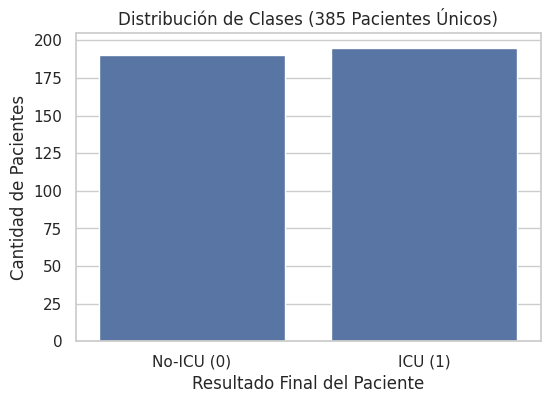

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer el estilo de los gráficos
sns.set(style="whitegrid")

if 'df_clinico' in locals():
    # Calculamos la etiqueta final para cada paciente (1 si fue a UCI en cualquier momento, 0 si no)
    # Esto es idéntico a cómo generamos 'y_labels' en la Fase 2.5
    y_labels_eda = df_clinico.groupby('PATIENT_VISIT_IDENTIFIER')['ICU'].max()

    # Contar los valores
    icu_counts = y_labels_eda.value_counts()
    print(f"Pacientes No-ICU (0): {icu_counts.get(0, 0)}")
    print(f"Pacientes ICU (1):    {icu_counts.get(1, 0)}")
    print(f"Total de pacientes:   {len(y_labels_eda)}")

    # Graficar
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=y_labels_eda)
    ax.set_xticklabels(['No-ICU (0)', 'ICU (1)'])
    plt.title('Distribución de Clases (385 Pacientes Únicos)')
    plt.xlabel('Resultado Final del Paciente')
    plt.ylabel('Cantidad de Pacientes')
    plt.show()
else:
    print("El DataFrame 'df_clinico' no está cargado. Ejecuta la Fase 2 primero.")

Como muestra el gráfico de barras, el dataset está excepcionalmente bien balanceado:

*   Pacientes No-ICU (0): 190 (49.4%)
*   Pacientes ICU (1): 195 (50.6%)

Esto es un escenario ideal. No requerimos técnicas de re-muestreo (como SMOTE) ni asignación de pesos de clase (class_weights) durante el entrenamiento.

<a id="fase3-2"><a/>
### 3.2. Análisis 2: Magnitud de Datos Faltantes (NaN)

En la Fase 2.4, definimos una estrategia de imputación en dos pasos (ffill + fillna(0)) asumiendo que el dataset tenía una "alta cardinalidad de valores ausentes". Este análisis busca cuantificar y visualizar exactamente cuán grave es el problema de los datos faltantes, justificando por qué un método simple (como rellenar con la media) sería inadecuado.

Total de columnas con datos faltantes: 225 de 231


/tmp/ipython-input-2187771254.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.head(30).values, y=missing_pct.head(30).index, palette="viridis")


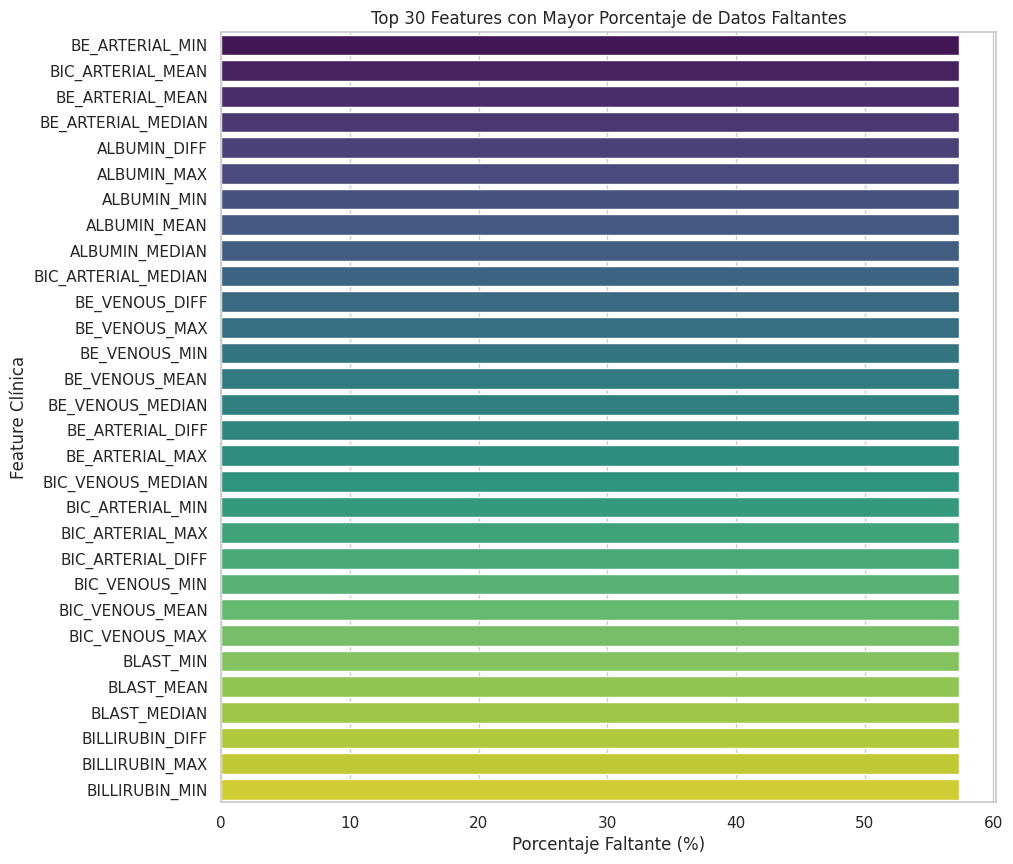

In [ ]:
if 'df_clinico' in locals():
    # Calcular el porcentaje de valores faltantes por columna
    missing_pct = df_clinico.isnull().mean() * 100

    # Filtrar solo las columnas que tienen datos faltantes y ordenarlas
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

    print(f"Total de columnas con datos faltantes: {len(missing_pct)} de {df_clinico.shape[1]}")

    # Graficar el Top 30 de features con más datos faltantes
    plt.figure(figsize=(10, 10))
    sns.barplot(x=missing_pct.head(30).values, y=missing_pct.head(30).index, palette="viridis")
    plt.title('Top 30 Features con Mayor Porcentaje de Datos Faltantes')
    plt.xlabel('Porcentaje Faltante (%)')
    plt.ylabel('Feature Clínica')
    plt.show()
else:
    print("El DataFrame 'df_clinico' no está cargado.")

El análisis confirma la hipótesis: 225 de las 231 columnas de features presentan datos faltantes.

El gráfico de las "Top 30" es revelador: muestra que las 30 features con más valores ausentes (principalmente análisis de laboratorio como BE_ARTERIAL_MEAN, ALBUMIN_DIFF y BIC_VENOUS_MAX) tienen más de un 50% de sus datos faltantes.

Esto valida que nuestra estrategia de imputación de la Fase 2.4 es fundamental. Usar la media o la mediana en columnas con un 50% de valores nulos distorsionaría por completo el dataset y generaría patrones artificiales.

<a id="fase3-3"></a>
### 3.3. Análisis 3: Patrones Temporales (Validación H₂.2)

Este es el análisis más importante para justificar el uso de una RNN (LSTM). La Hipótesis H₂.2 postula que las RNN pueden capturar "patrones temporales predictivos".

Si no existen diferencias en los signos vitales a lo largo del tiempo entre los pacientes que van a UCI y los que no, un modelo RNN sería inútil. Este gráfico busca encontrar evidencia visual de que esos patrones divergentes realmente existen en los datos.

DataFrame temporal para EDA creado.
Generando gráficos de patrones temporales...


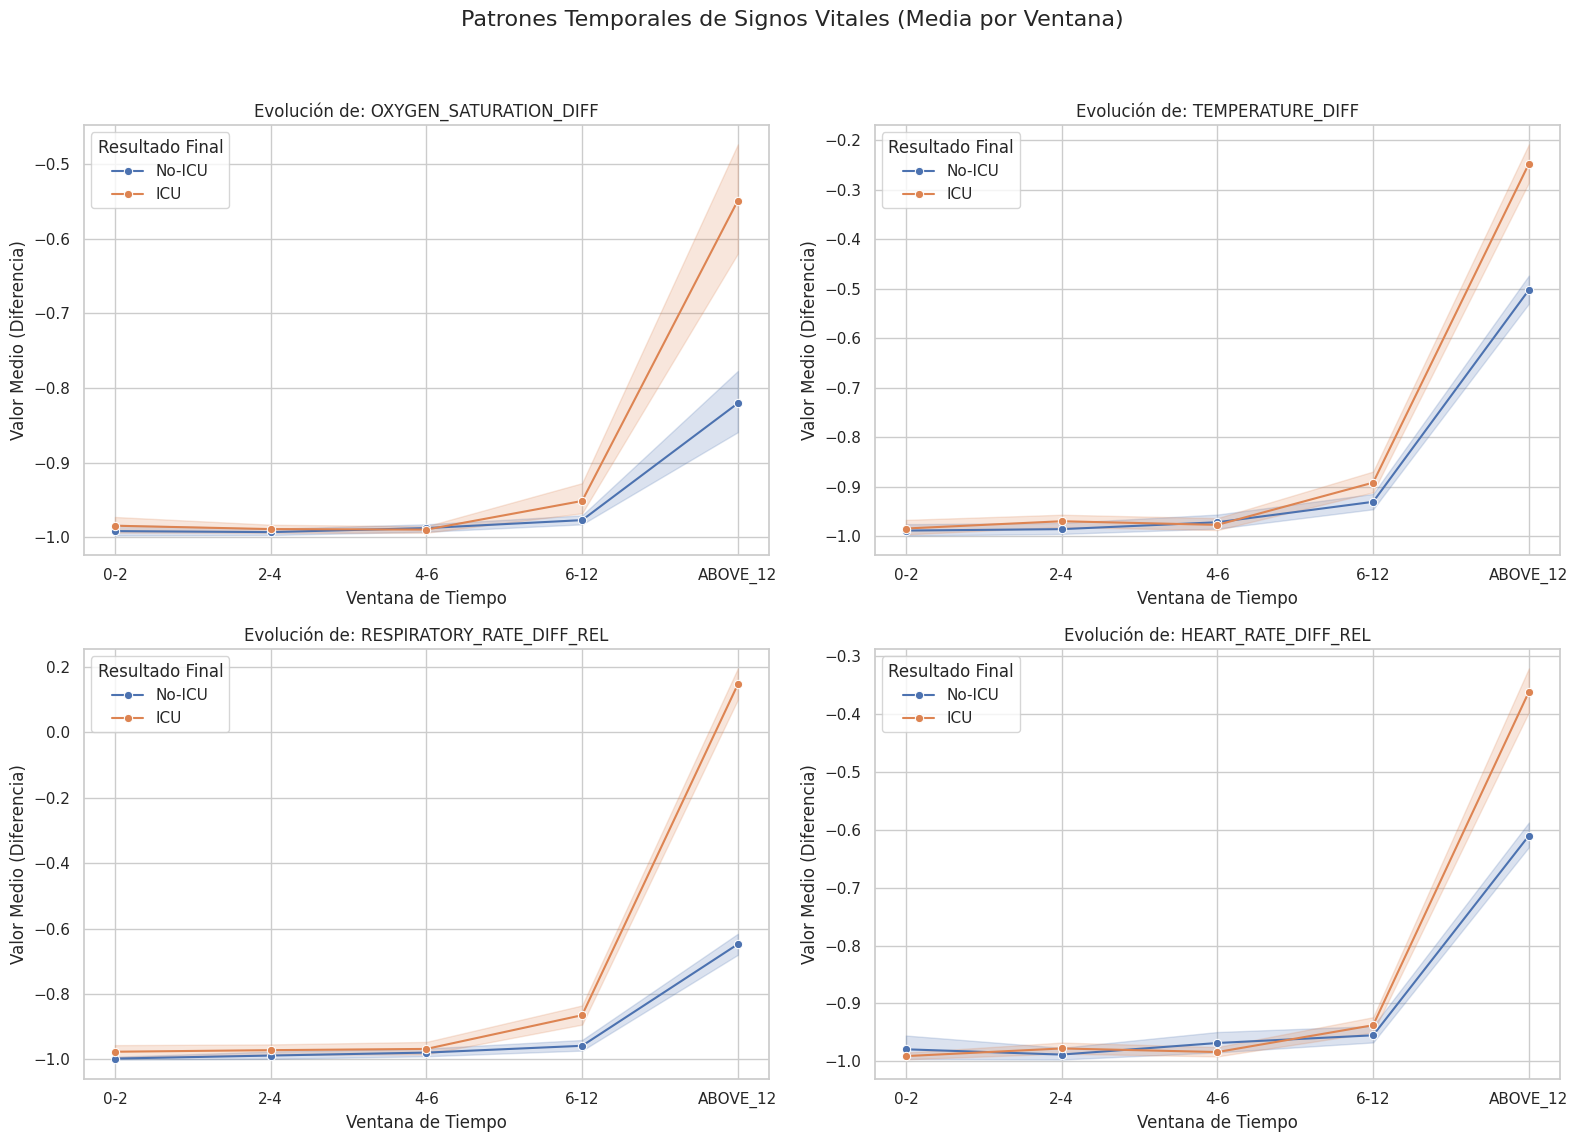

In [ ]:
if 'df_eda_temporal' not in locals():
    # Este análisis requiere el 'y_labels_eda' del Análisis 1.
    # Necesitamos mapear la etiqueta final (ICU=1 o 0) de vuelta a cada fila de ventana de tiempo.
    try:
        patient_outcomes = y_labels_eda.to_frame(name='ICU_FINAL')
        df_eda_temporal = df_clinico.join(patient_outcomes, on='PATIENT_VISIT_IDENTIFIER')
        print("DataFrame temporal para EDA creado.")
    except NameError:
        print("Ejecuta el Análisis 3.1 primero para crear 'y_labels_eda'.")

if 'df_eda_temporal' in locals():
    # Definir el orden correcto de las ventanas
    window_order = ['0-2', '2-4', '4-6', '6-12', 'ABOVE_12']

    # --- CORRECCIÓN AQUÍ ---
    # Convertir la columna 'WINDOW' a un tipo Categórico Ordenado
    # Esto asegura que sns.lineplot grafique el eje X en el orden correcto.
    df_eda_temporal['WINDOW'] = pd.Categorical(df_eda_temporal['WINDOW'], categories=window_order, ordered=True)

    # Lista de signos vitales clave para analizar (basado en las columnas de Celda 5)
    vitals_to_plot = [
        'OXYGEN_SATURATION_DIFF',
        'TEMPERATURE_DIFF',
        'RESPIRATORY_RATE_DIFF_REL',
        'HEART_RATE_DIFF_REL'
    ]

    print("Generando gráficos de patrones temporales...")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    fig.suptitle('Patrones Temporales de Signos Vitales (Media por Ventana)', fontsize=16)

    axes_flat = axes.flatten()

    for i, vital in enumerate(vitals_to_plot):
        sns.lineplot(
            data=df_eda_temporal,
            x='WINDOW',
            y=vital,
            hue='ICU_FINAL',
            # order=window_order,  <-- ESTA LÍNEA SE ELIMINÓ (CAUSABA EL ERROR)
            marker='o',
            ax=axes_flat[i]
        )
        axes_flat[i].set_title(f'Evolución de: {vital}')
        axes_flat[i].set_xlabel('Ventana de Tiempo')
        axes_flat[i].set_ylabel('Valor Medio (Diferencia)')
        handles, labels = axes_flat[i].get_legend_handles_labels()
        axes_flat[i].legend(handles, ['No-ICU', 'ICU'], title='Resultado Final')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("eda_temporal_patterns.png")
    plt.show()

Los cuatro gráficos de líneas proporcionan una confirmación visual clara de la Hipótesis H₂.2.

En los cuatro signos vitales analizados, se observa un patrón idéntico:

* Ventanas Tempranas (0-6h): Las líneas de los pacientes "No-ICU" (azul) y "ICU" (naranja) son casi indistinguibles. En las primeras horas, ambos grupos de pacientes se "ven" clínicamente similares.
* Ventanas Tardías (6-12h y ABOVE_12h): Ocurre una divergencia drástica. Los pacientes que eventualmente ingresarán a UCI muestran un rápido empeoramiento (ej. la OXYGEN_SATURATION_DIFF cae en picada y la RESPIRATORY_RATE_DIFF_REL aumenta), mientras que los pacientes No-ICU se mantienen estables o mejoran.

Conclusión: El dataset contiene señales temporales fuertes y claras. Esto demuestra que un modelo RNN (LSTM) es una elección de arquitectura excelente, ya que está diseñado específicamente para aprender este tipo de divergencias en secuencias de datos.

---

<a id="fase4"></a>
## 4. Fase 4: Diseño, Entrenamiento y Validación de Modelos

En esta fase, optimizaremos, definiremos y entrenaremos las cuatro arquitecturas de modelos.

<a id="fase4-1"></a>
### 4.1. División de Datos (Train/Validation/Test)


In [ ]:
from sklearn.model_selection import train_test_split

# --- Porcentaje de división ---\n",
# 80% Train, 10% Val, 10% Test
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1 # 1.0 - TRAIN_SIZE - VAL_SIZE

# --- 1. Dividir Secuencias ICU (Clase 1) ---
train_seq_icu, temp_seq_icu = train_test_split(
    x_seq_icu, test_size=(1.0 - TRAIN_SIZE), random_state=42
)
val_seq_icu, test_seq_icu = train_test_split(
    temp_seq_icu, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42
)

# --- 2. Dividir Secuencias NO-ICU (Clase 0) ---
train_seq_no_icu, temp_seq_no_icu = train_test_split(
    x_seq_no_icu, test_size=(1.0 - TRAIN_SIZE), random_state=42
)
val_seq_no_icu, test_seq_no_icu = train_test_split(
    temp_seq_no_icu, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42
)

# --- 3. Dividir Imágenes COVID (Clase 1) ---
train_img_covid, temp_img_covid = train_test_split(
    x_images_covid, test_size=(1.0 - TRAIN_SIZE), random_state=42
)
val_img_covid, test_img_covid = train_test_split(
    temp_img_covid, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42
)

# --- 4. Dividir Imágenes NORMAL (Clase 0) ---
train_img_normal, temp_img_normal = train_test_split(
    x_images_normal, test_size=(1.0 - TRAIN_SIZE), random_state=42
)
val_img_normal, test_img_normal = train_test_split(
    temp_img_normal, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=42
)

# --- Verificación de las divisiones ---\n",
print("--- TAMAÑO DE SPLITS (ENTRENAMIENTO) ---")
print(f"Secuencias ICU: {len(train_seq_icu)} | Imágenes COVID: {len(train_img_covid)}")
print(f"Secuencias No-ICU: {len(train_seq_no_icu)} | Imágenes Normal: {len(train_img_normal)}")

print("\n--- TAMAÑO DE SPLITS (VALIDACIÓN) ---")
print(f"Secuencias ICU: {len(val_seq_icu)} | Imágenes COVID: {len(val_img_covid)}")
print(f"Secuencias No-ICU: {len(val_seq_no_icu)} | Imágenes Normal: {len(val_img_normal)}")

print("\n--- TAMAÑO DE SPLITS (PRUEBA/TEST) ---")
print(f"Secuencias ICU: {len(test_seq_icu)} | Imágenes COVID: {len(test_img_covid)}")
print(f"Secuencias No-ICU: {len(test_seq_no_icu)} | Imágenes Normal: {len(test_img_normal)}")

--- TAMAÑO DE SPLITS (ENTRENAMIENTO) ---
Secuencias ICU: 156 | Imágenes COVID: 1300
Secuencias No-ICU: 152 | Imágenes Normal: 1441

--- TAMAÑO DE SPLITS (VALIDACIÓN) ---
Secuencias ICU: 19 | Imágenes COVID: 163
Secuencias No-ICU: 19 | Imágenes Normal: 180

--- TAMAÑO DE SPLITS (PRUEBA/TEST) ---
Secuencias ICU: 20 | Imágenes COVID: 163
Secuencias No-ICU: 19 | Imágenes Normal: 181


#### 4.1.2. Creación de Arrays (RNN-Only)

In [ ]:
import numpy as np
from sklearn.utils import shuffle

# --- 1. Crear set de Entrenamiento ---
# Concatenar las secuencias de clase 1 (ICU) y clase 0 (No ICU)
X_train_rnn = np.concatenate((train_seq_icu, train_seq_no_icu), axis=0)
# Crear las etiquetas correspondientes (1s y 0s)
y_train_rnn = np.concatenate((
    np.ones(len(train_seq_icu)),
    np.zeros(len(train_seq_no_icu))
), axis=0)
# Mezclarlas
X_train_rnn, y_train_rnn = shuffle(X_train_rnn, y_train_rnn, random_state=42)

# --- 2. Crear set de Validación ---
X_val_rnn = np.concatenate((val_seq_icu, val_seq_no_icu), axis=0)
y_val_rnn = np.concatenate((
    np.ones(len(val_seq_icu)),
    np.zeros(len(val_seq_no_icu))
), axis=0)
X_val_rnn, y_val_rnn = shuffle(X_val_rnn, y_val_rnn, random_state=42)

# --- 3. Crear set de Prueba (para el final) ---
X_test_rnn = np.concatenate((test_seq_icu, test_seq_no_icu), axis=0)
y_test_rnn = np.concatenate((
    np.ones(len(test_seq_icu)),
    np.zeros(len(test_seq_no_icu))
), axis=0)
X_test_rnn, y_test_rnn = shuffle(X_test_rnn, y_test_rnn, random_state=42)

print("Datos RNN-Only listos:")
print(f"  X_train_rnn shape: {X_train_rnn.shape} | y_train_rnn shape: {y_train_rnn.shape}")
print(f"  X_val_rnn shape:   {X_val_rnn.shape}   | y_val_rnn shape: {y_val_rnn.shape}")
print(f"  X_test_rnn shape:  {X_test_rnn.shape}    | y_test_rnn shape: {y_test_rnn.shape}")

Datos RNN-Only listos:
  X_train_rnn shape: (308, 5, 228) | y_train_rnn shape: (308,)
  X_val_rnn shape:   (38, 5, 228)   | y_val_rnn shape: (38,)
  X_test_rnn shape:  (39, 5, 228)    | y_test_rnn shape: (39,)


#### 4.1.3. Definición de Generadores de Datos

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import numpy as np

# Definimos el tamaño del batch
BATCH_SIZE = 16

class MultimodalDataGenerator(Sequence):

    def __init__(self, img_covid, seq_icu, img_normal, seq_no_icu,
                 batch_size, img_size, shuffle=True, **kwargs):

        super().__init__(**kwargs)

        # 1. Guardar las 4 piscinas de datos
        self.img_covid = img_covid
        self.seq_icu = seq_icu
        self.img_normal = img_normal
        self.seq_no_icu = seq_no_icu

        # 2. Parámetros
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle # Añadido para controlar el shuffle en 'test'

        # 3. Combinar para obtener etiquetas en orden (necesario para el cálculo de __len__)
        self.all_seqs = np.concatenate((self.seq_icu, self.seq_no_icu), axis=0)
        self.all_imgs = self.img_covid + self.img_normal # Usado para emparejamiento aleatorio
        self.labels = [1] * len(self.seq_icu) + [0] * len(self.seq_no_icu)

        self.n_samples = len(self.labels)
        self.on_epoch_end()

    def __len__(self):
        # Usar 'ceil' (techo) para asegurar que se incluyan todas las muestras
        return int(np.ceil(self.n_samples / self.batch_size))

    def on_epoch_end(self):
        # Mezclar datos si el shuffle está activado (para train/val)
        if self.shuffle:
            indices = np.arange(self.n_samples)
            np.random.shuffle(indices)
            self.all_seqs = self.all_seqs[indices]
            self.labels = [self.labels[i] for i in indices]

    def _load_image(self, img_path):
        # Cargar y pre-procesar una imagen
        img = load_img(img_path, target_size=self.img_size, color_mode='rgb')
        img_array = img_to_array(img)
        return img_array / 255.0

    def __getitem__(self, index):
        # Obtener los índices del batch actual
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.n_samples)

        current_batch_size = end_idx - start_idx

        # Obtener las secuencias y etiquetas para este batch
        batch_x_seq = self.all_seqs[start_idx:end_idx]
        batch_y = self.labels[start_idx:end_idx]

        # Emparejar aleatoriamente las imágenes
        batch_x_img = []
        for label in batch_y:
            if label == 1:
                img_path = random.choice(self.img_covid)
            else:
                img_path = random.choice(self.img_normal)
            batch_x_img.append(self._load_image(img_path))

        # Retornar como diccionario para el modelo multimodal
        x_batch_dict = {
            'input_imagen': np.array(batch_x_img),
            'input_secuencia': np.array(batch_x_seq)
        }
        y_batch_array = np.array(batch_y)

        return (x_batch_dict, y_batch_array)

In [ ]:
import math

class CNNSoloDataGenerator(Sequence):

    def __init__(self, img_class_1, img_class_0, batch_size, img_size, shuffle=True, **kwargs):

        super().__init__(**kwargs)

        # 1. Guardar las listas de rutas
        self.img_class_1 = img_class_1 # COVID
        self.img_class_0 = img_class_0 # NORMAL

        # 2. Combinar y crear etiquetas
        self.all_img_paths = self.img_class_1 + self.img_class_0
        self.labels = [1] * len(self.img_class_1) + [0] * len(self.img_class_0)

        # 3. Parámetros
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.n_samples = len(self.labels)

        self.on_epoch_end() # Mezclar al inicio

    def __len__(self):
        # Número total de batches por época
        return int(np.ceil(self.n_samples / self.batch_size))

    def on_epoch_end(self):
        # Mezclar datos al final de cada época si shuffle=True
        if self.shuffle:
            temp = list(zip(self.all_img_paths, self.labels))
            np.random.shuffle(temp)
            self.all_img_paths, self.labels = list(zip(*temp)) # Convertir tuplas de zip a listas

    def _load_image(self, img_path):
        # Cargar y pre-procesar
        img = load_img(img_path, target_size=self.img_size, color_mode='rgb')
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalizar
        return img_array

    def __getitem__(self, index):
        # 1. Obtener los índices del batch
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, self.n_samples)

        # 2. Seleccionar las rutas y etiquetas del batch
        batch_paths = self.all_img_paths[start_idx:end_idx]
        batch_labels = self.labels[start_idx:end_idx]

        # 3. Cargar las imágenes
        batch_x_img = [self._load_image(p) for p in batch_paths]

        # 4. Retornar X e Y
        return (np.array(batch_x_img), np.array(batch_labels))

print("Clases MultimodalDataGenerator y CNNSoloDataGenerator definidas.")

Clases MultimodalDataGenerator y CNNSoloDataGenerator definidas.


#### 4.1.4. Instanciación de Generadores

In [ ]:
try:
    N_FEATURES = n_features
except NameError:
    N_FEATURES = x_sequences.shape[2] # Aseguramos que N_FEATURES exista

SEQ_LENGTH = 5
IMG_SIZE = (128, 128)

# Instanciar el generador de Entrenamiento
train_gen = MultimodalDataGenerator(
    img_covid=train_img_covid,
    seq_icu=train_seq_icu,
    img_normal=train_img_normal,
    seq_no_icu=train_seq_no_icu,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True,
    workers=4,
    use_multiprocessing=True
)

# Instanciar el generador de Validación
val_gen = MultimodalDataGenerator(
    img_covid=val_img_covid,
    seq_icu=val_seq_icu,
    img_normal=val_img_normal,
    seq_no_icu=val_seq_no_icu,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True,
    workers=4,
    use_multiprocessing=True
)

# Instanciar el generador de Prueba
# Usamos shuffle=False para que las predicciones sean consistentes en la Fase 5
test_gen = MultimodalDataGenerator(
    img_covid=test_img_covid,
    seq_icu=test_seq_icu,
    img_normal=test_img_normal,
    seq_no_icu=test_seq_no_icu,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False,
    workers=4,
    use_multiprocessing=True
)

print(f"Generador Multimodal de entrenamiento creado: {len(train_gen)} batches")
print(f"Generador Multimodal de validación creado: {len(val_gen)} batches")
print(f"Generador Multimodal de prueba creado: {len(test_gen)} batches")

Generador Multimodal de entrenamiento creado: 20 batches
Generador Multimodal de validación creado: 3 batches
Generador Multimodal de prueba creado: 3 batches


In [ ]:
# Instanciar los generadores para el modelo CNN-Only
train_gen_cnn = CNNSoloDataGenerator(
    img_class_1=train_img_covid,
    img_class_0=train_img_normal,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True,
    workers=4,
    use_multiprocessing=True
)

val_gen_cnn = CNNSoloDataGenerator(
    img_class_1=val_img_covid,
    img_class_0=val_img_normal,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True,
    workers=4,
    use_multiprocessing=True
)

test_gen_cnn = CNNSoloDataGenerator(
    img_class_1=test_img_covid,
    img_class_0=test_img_normal,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False,
    workers=4,
    use_multiprocessing=True
)

print(f"\nGenerador CNN-Only de entrenamiento creado: {len(train_gen_cnn)} batches")
print(f"Generador CNN-Only de validación creado: {len(val_gen_cnn)} batches")
print(f"Generador CNN-Only de prueba creado: {len(test_gen_cnn)} batches")


Generador CNN-Only de entrenamiento creado: 172 batches
Generador CNN-Only de validación creado: 22 batches
Generador CNN-Only de prueba creado: 22 batches


### 4.2. Optimización de Hiperparámetros (KerasTuner)

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall

# Definimos las métricas que usaremos en todos los modelos
# Incluimos 'accuracy' que KerasTuner puede rastrear fácilmente
METRICS = [
    AUC(name='roc_auc'),
    Precision(name='precision'),
    Recall(name='recall'),
    'accuracy'
]

print("KerasTuner instalado e importado. Métricas definidas.")

KerasTuner instalado e importado. Métricas definidas.


#### 4.2.1. Optimización del Modelo RNN-Only

In [ ]:
def build_rnn_model(hp):
    """
    Función de construcción de modelo RNN para KerasTuner.
    """
    # 1. Definir el rango de búsqueda de hiperparámetros
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32) # Probará 32, 64, 96, 128
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1) # Probará 0.2, 0.3, 0.4, 0.5
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]) # Probará 3 tasas de aprendizaje

    # 2. Arquitectura del Modelo
    seq_input_rnn = tf.keras.layers.Input(shape=(SEQ_LENGTH, N_FEATURES), name='input_secuencia_rnn')

    y = tf.keras.layers.LSTM(units=hp_units, return_sequences=False, name='lstm_layer')(seq_input_rnn)
    y = tf.keras.layers.Dropout(rate=hp_dropout)(y) # Usar dropout del sintonizador
    y = tf.keras.layers.Dense(units=hp_units//2, activation='relu', name='features_rnn')(y) # Capa densa proporcional

    z = tf.keras.layers.Dense(64, activation='relu', name='capa_densa_fusion')(y)
    z = tf.keras.layers.Dropout(0.5)(z)
    output_rnn = tf.keras.layers.Dense(1, activation='sigmoid', name='output_clasificacion')(z)

    model_rnn = tf.keras.models.Model(inputs=seq_input_rnn, outputs=output_rnn, name='modelo_RNN_Only')

    # 3. Compilación
    model_rnn.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss=BinaryCrossentropy(),
        metrics=METRICS
    )
    return model_rnn

build_rnn_model(kt.HyperParameters()).summary()

Model: "modelo_RNN_Only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_secuencia_rnn             │ (None, 5, 228)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 32)             │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features_rnn (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_densa_fusion (Dense)       │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clasificacion (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,089 (137.07 KB)

 Trainable params: 35,089 (137.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. Configurar el Sintonizador (Tuner) - Versión HYPERBAND
rnn_tuner = kt.Hyperband(
    build_rnn_model,
    objective=kt.Objective("val_roc_auc", direction="max"),
    max_epochs=30,
    factor=3,
    directory='kerastuner_rnn_hb',
    project_name='icu_rnn_tuning_hyperband',
    overwrite=True
)

# Mostrar un resumen
print("Espacio de búsqueda de Hiperparámetros (RNN - Hyperband):")
rnn_tuner.search_space_summary()

# 2. Ejecutar la Búsqueda
print("\n--- Iniciando búsqueda de hiperparámetros para RNN (Hyperband) ---")
# KerasTuner maneja su propio EarlyStopping interno con Hyperband,
# pero podemos añadir uno para el "patience" general de la búsqueda.
stop_early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

rnn_tuner.search(
    X_train_rnn,
    y_train_rnn,
    epochs=30,
    validation_data=(X_val_rnn, y_val_rnn),
    callbacks=[stop_early_cb]
)
print("--- Búsqueda de RNN finalizada ---")


# 3. Obtener y mostrar los mejores hiperparámetros
# Obtenemos el mejor modelo de todos los brackets
best_rnn_hps = rnn_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\n--- Mejores Hiperparámetros para RNN (encontrados por KerasTuner) ---")
print(f"  > Units (LSTM):    {best_rnn_hps.get('units')}")
print(f"  > Dropout:         {best_rnn_hps.get('dropout')}")
print(f"  > Learning Rate:   {best_rnn_hps.get('learning_rate')}")

Trial 54 Complete [00h 00m 07s]
val_roc_auc: 0.63434898853302

Best val_roc_auc So Far: 1.0
Total elapsed time: 00h 04m 51s
--- Búsqueda de RNN finalizada ---

--- Mejores Hiperparámetros para RNN (encontrados por KerasTuner) ---
  > Units (LSTM):    96
  > Dropout:         0.2
  > Learning Rate:   0.001


#### 4.2.2. Optimización del Modelo CNN-Only

In [ ]:
def build_cnn_model(hp):
    """
    Función de construcción de modelo CNN para KerasTuner.
    """
    # 1. Definir el rango de búsqueda de hiperparámetros
    hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=32, step=16) # Probará 16, 32
    hp_filters_2 = hp.Int('filters_2', min_value=32, max_value=64, step=32) # Probará 32, 64
    hp_filters_3 = hp.Int('filters_3', min_value=64, max_value=128, step=32) # Probará 64, 96, 128
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # 2. Arquitectura del Modelo (basada en la Celda 21 original)
    image_input_cnn = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='input_imagen_cnn')

    x = tf.keras.layers.Conv2D(filters=hp_filters_1, kernel_size=(3, 3), activation='relu')(image_input_cnn)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(filters=hp_filters_2, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(filters=hp_filters_3, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    cnn_features = tf.keras.layers.Dense(64, activation='relu', name='features_cnn')(x)

    z = tf.keras.layers.Dense(64, activation='relu', name='capa_densa_fusion')(cnn_features)
    z = tf.keras.layers.Dropout(0.5)(z)
    output_cnn = tf.keras.layers.Dense(1, activation='sigmoid', name='output_clasificacion')(z)

    model_cnn = tf.keras.models.Model(inputs=image_input_cnn, outputs=output_cnn, name='modelo_CNN_Only')

    # 3. Compilación
    model_cnn.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss=BinaryCrossentropy(),
        metrics=METRICS
    )
    return model_cnn

# Imprimir un resumen de un modelo de prueba para verificar
build_cnn_model(kt.HyperParameters()).summary()

Model: "modelo_CNN_Only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_imagen_cnn (InputLayer)   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features_cnn (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_densa_fusion (Dense)       │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clasificacion (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,193 (125.75 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# 1. Configurar el Sintonizador (Tuner) - Versión HYPERBAND
cnn_tuner = kt.Hyperband(
    build_cnn_model,
    objective=kt.Objective("val_roc_auc", direction="max"),
    max_epochs=15,
    factor=3,
    directory='kerastuner_cnn_hb',
    project_name='icu_cnn_tuning_hyperband',
    overwrite=True
)

# Mostrar un resumen
print("Espacio de búsqueda de Hiperparámetros (CNN - Hyperband):")
cnn_tuner.search_space_summary()

# 2. Ejecutar la Búsqueda
print("\n--- Iniciando búsqueda de hiperparámetros para CNN ---")
stop_early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

cnn_tuner.search(
    train_gen_cnn,
    epochs=15,
    validation_data=val_gen_cnn,
    callbacks=[stop_early_cb]
)
print("--- Búsqueda de CNN finalizada ---")

# 3. Obtener y mostrar los mejores hiperparámetros
best_cnn_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\n--- Mejores Hiperparámetros para CNN (encontrados por KerasTuner) ---")
print(f"  > Filtros 1 (Capa Conv2D 1): {best_cnn_hps.get('filters_1')}")
print(f"  > Filtros 2 (Capa Conv2D 2): {best_cnn_hps.get('filters_2')}")
print(f"  > Filtros 3 (Capa Conv2D 3): {best_cnn_hps.get('filters_3')}")
print(f"  > Learning Rate:             {best_cnn_hps.get('learning_rate')}")

Trial 30 Complete [00h 03m 49s]
val_roc_auc: 0.9648943543434143

Best val_roc_auc So Far: 0.9994376301765442
Total elapsed time: 00h 47m 49s
--- Búsqueda de CNN finalizada ---

--- Mejores Hiperparámetros para CNN (encontrados por KerasTuner) ---
  > Filtros 1 (Capa Conv2D 1): 16
  > Filtros 2 (Capa Conv2D 2): 64
  > Filtros 3 (Capa Conv2D 3): 64
  > Learning Rate:             0.001


#### 4.2.3. Registro de Experimentos

Se realizó un proceso de optimización de hiperparámetros usando `KerasTuner` con la estrategia `Hyperband` para encontrar los parámetros óptimos de los modelos base.

Tras ejecutar la búsqueda , los parámetros seleccionados para el entrenamiento final son:

| Modelo | Hiperparámetro | Rango Probado | Valor Seleccionado |
| :--- | :--- | :--- | :--- |
| **RNN-Only** | LSTM Units | [32, 64, 96, 128] | **96** |
| | Dropout | [0.2, 0.3, 0.4, 0.5] | **0.2** |
| | Learning Rate | [1e-3, 1e-4, 1e-5] | **0.001** |
| **CNN-Only** | Filtros (Capa 1) | [16, 32] | **16** |
| | Filtros (Capa 2) | [32, 64] | **64** |
| | Filtros (Capa 3) | [64, 96, 128] | **64** |
| | Learning Rate | [1e-3, 1e-4, 1e-5] | **0.001** |

A continuación, se entrenan los modelos finales usando estos parámetros optimizados.

### 4.3 Entrenamiento de los Modelos

#### 4.3.1 Entrenamiento Modelo: RNN-Only

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Definir Arquitectura RNN-Only ---
# (Basado en la arquitectura del sintonizador)
seq_input_rnn = Input(shape=(SEQ_LENGTH, N_FEATURES), name='input_secuencia_rnn')

y = LSTM(units=96, return_sequences=False, name='lstm_layer')(seq_input_rnn)
y = Dropout(rate=0.2)(y)
y = Dense(units=48, activation='relu', name='features_rnn')(y) # 48 = 96 (units) / 2

# Cabeza clasificadora (idéntica a la fusión)
z = Dense(64, activation='relu', name='capa_densa_fusion')(y)
z = Dropout(0.5)(z)
output_rnn = Dense(1, activation='sigmoid', name='output_clasificacion')(z)

model_rnn = Model(inputs=seq_input_rnn, outputs=output_rnn, name='modelo_RNN_Only_Optimizado')
print("Arquitectura RNN-Only (Optimizada):")
model_rnn.summary()

# --- 2. Compilar y Entrenar ---
OPTIMIZER_RNN = Adam(learning_rate=0.001)
LOSS_RNN = BinaryCrossentropy()

model_rnn.compile(
    optimizer=OPTIMIZER_RNN,
    loss=LOSS_RNN,
    metrics=METRICS
)
print("\nModelo RNN-Only compilado.")

checkpoint_path_rnn = os.path.join(BASE_DIR, "best_rnn_only_model_v2.h5")
model_checkpoint_rnn = ModelCheckpoint(
    filepath=checkpoint_path_rnn, monitor='val_roc_auc', mode='max', save_best_only=True, verbose=1
)
early_stopping_rnn = EarlyStopping(
    monitor='val_roc_auc', mode='max', patience=5, verbose=1, restore_best_weights=True
)

print("--- INICIANDO ENTRENAMIENTO FINAL (RNN-Only) ---")
history_rnn = model_rnn.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=30, # Entrenamiento más largo
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_rnn, early_stopping_rnn],
    verbose=1
)
print("\n--- ENTRENAMIENTO RNN-Only FINALIZADO ---")

Arquitectura RNN-Only (Optimizada):


Model: "modelo_RNN_Only_Optimizado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_secuencia_rnn             │ (None, 5, 228)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 96)             │       124,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features_rnn (Dense)            │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_densa_fusion (Dense)       │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clasificacion (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,657 (518.19 KB)

 Trainable params: 132,657 (518.19 KB)

 Non-trainable params: 0 (0.00 B)


Modelo RNN-Only compilado.
--- INICIANDO ENTRENAMIENTO FINAL (RNN-Only) ---
Epoch 1/30
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4644 - loss: 0.7069 - precision: 0.5107 - recall: 0.4089 - roc_auc: 0.4843
Epoch 1: val_roc_auc improved from -inf to 0.93490, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4841 - loss: 0.6996 - precision: 0.5217 - recall: 0.4384 - roc_auc: 0.5113 - val_accuracy: 0.7105 - val_loss: 0.5785 - val_precision: 0.9000 - val_recall: 0.4737 - val_roc_auc: 0.9349
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7323 - loss: 0.5711 - precision: 0.7762 - recall: 0.6380 - roc_auc: 0.7998
Epoch 2: val_roc_auc improved from 0.93490 to 0.95568, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7327 - loss: 0.5702 - precision: 0.7750 - recall: 0.6424 - roc_auc: 0.8002 - val_accuracy: 0.8947 - val_loss: 0.3823 - val_precision: 0.8947 - val_recall: 0.8947 - val_roc_auc: 0.9557
Epoch 3/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8063 - loss: 0.4667 - precision: 0.8340 - recall: 0.7545 - roc_auc: 0.8587
Epoch 3: val_roc_auc improved from 0.95568 to 0.96953, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8034 - loss: 0.4671 - precision: 0.8293 - recall: 0.7559 - roc_auc: 0.8585 - val_accuracy: 0.8684 - val_loss: 0.3024 - val_precision: 0.9375 - val_recall: 0.7895 - val_roc_auc: 0.9695
Epoch 4/30
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7830 - loss: 0.4576 - precision: 0.8455 - recall: 0.6555 - roc_auc: 0.8706
Epoch 4: val_roc_auc improved from 0.96953 to 0.97230, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7879 - loss: 0.4487 - precision: 0.8462 - recall: 0.6751 - roc_auc: 0.8752 - val_accuracy: 0.8947 - val_loss: 0.2578 - val_precision: 0.8947 - val_recall: 0.8947 - val_roc_auc: 0.9723
Epoch 5/30
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8463 - loss: 0.3595 - precision: 0.8792 - recall: 0.8290 - roc_auc: 0.9240
Epoch 5: val_roc_auc improved from 0.97230 to 0.98338, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8474 - loss: 0.3596 - precision: 0.8777 - recall: 0.8312 - roc_auc: 0.9241 - val_accuracy: 0.8947 - val_loss: 0.2103 - val_precision: 0.8947 - val_recall: 0.8947 - val_roc_auc: 0.9834
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8843 - loss: 0.3200 - precision: 0.9201 - recall: 0.8477 - roc_auc: 0.9385
Epoch 6: val_roc_auc improved from 0.98338 to 0.98892, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8842 - loss: 0.3199 - precision: 0.9194 - recall: 0.8482 - roc_auc: 0.9385 - val_accuracy: 0.8947 - val_loss: 0.1729 - val_precision: 0.8571 - val_recall: 0.9474 - val_roc_auc: 0.9889
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8790 - loss: 0.3071 - precision: 0.8611 - recall: 0.8941 - roc_auc: 0.9330
Epoch 7: val_roc_auc did not improve from 0.98892
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8789 - loss: 0.3070 - precision: 0.8612 - recall: 0.8943 - roc_auc: 0.9335 - val_accuracy: 0.8947 - val_loss: 0.2156 - val_precision: 1.0000 - val_recall: 0.7895 - val_roc_auc: 0.9889
Epoch 8/30
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9071 - loss: 0.2588 - precision: 0.9586 - recall: 0.8593 - roc_auc: 0.9624
Epoch 8: val_roc_auc improved from 0.98892 to 0.99169, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9064 - loss: 0.2580 - precision: 0.9539 - recall: 0.8619 - roc_auc: 0.9619 - val_accuracy: 0.9474 - val_loss: 0.1542 - val_precision: 1.0000 - val_recall: 0.8947 - val_roc_auc: 0.9917
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9333 - loss: 0.2109 - precision: 0.9427 - recall: 0.9229 - roc_auc: 0.9704
Epoch 9: val_roc_auc improved from 0.99169 to 0.99723, saving model to drive/MyDrive/ia_lab_02/best_rnn_only_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9330 - loss: 0.2111 - precision: 0.9424 - recall: 0.9229 - roc_auc: 0.9704 - val_accuracy: 0.9474 - val_loss: 0.1594 - val_precision: 1.0000 - val_recall: 0.8947 - val_roc_auc: 0.9972
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9319 - loss: 0.1939 - precision: 0.9408 - recall: 0.9170 - roc_auc: 0.9751
Epoch 10: val_roc_auc did not improve from 0.99723
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9313 - loss: 0.1957 - precision: 0.9405 - recall: 0.9163 - roc_auc: 0.9746 - val_accuracy: 0.8421 - val_loss: 0.2841 - val_precision: 0.7600 - val_recall: 1.0000 - val_roc_auc: 0.9945
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8566 - loss: 0.2856 - precision: 0.8511 - recall: 0.9090 - roc_auc: 0.9547
Epoch 11: val_roc_auc did not improve from 0.99723
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8587 - loss: 0.2831 - precision: 0.8534 - recall: 0.9087 - roc_auc: 0.9554 - val_accur

#### 4.3.2 Entrenamiento Modelo: CNN-Only

In [ ]:
# --- 1. Definir Arquitectura CNN-Only ---
# (Basado en la arquitectura del sintonizador)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

image_input_cnn = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='input_imagen_cnn')

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input_cnn)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

cnn_features = Dense(64, activation='relu', name='features_cnn')(x)

# Cabeza clasificadora
z = Dense(64, activation='relu', name='capa_densa_fusion')(cnn_features)
z = Dropout(0.5)(z)
output_cnn = Dense(1, activation='sigmoid', name='output_clasificacion')(z)

model_cnn = Model(inputs=image_input_cnn, outputs=output_cnn, name='modelo_CNN_Only_Optimizado')
print("Arquitectura CNN-Only (Optimizada):")
model_cnn.summary()

# --- 2. Compilar y Entrenar ---
OPTIMIZER_CNN = Adam(learning_rate=0.001)
LOSS_CNN = BinaryCrossentropy()

model_cnn.compile(
    optimizer=OPTIMIZER_CNN,
    loss=LOSS_CNN,
    metrics=METRICS
)
print("\nModelo CNN-Only compilado.")

# Callbacks
checkpoint_path_cnn = os.path.join(BASE_DIR, "best_cnn_only_model_v2.h5")
model_checkpoint_cnn = ModelCheckpoint(
    filepath=checkpoint_path_cnn, monitor='val_roc_auc', mode='max', save_best_only=True, verbose=1
)
early_stopping_cnn = EarlyStopping(
    monitor='val_roc_auc', mode='max', patience=5, verbose=1, restore_best_weights=True
)

print("--- INICIANDO ENTRENAMIENTO FINAL (CNN-Only) ---")
history_cnn = model_cnn.fit(
    train_gen_cnn,
    validation_data=val_gen_cnn,
    epochs=30,
    callbacks=[model_checkpoint_cnn, early_stopping_cnn],
    verbose=1,
)
print("\n--- ENTRENAMIENTO CNN-Only FINALIZADO ---")

Arquitectura CNN-Only (Optimizada):


Model: "modelo_CNN_Only_Optimizado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_imagen_cnn (InputLayer)   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features_cnn (Dense)            │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_densa_fusion (Dense)       │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_clasificacion (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,617 (217.25 KB)

 Trainable params: 55,329 (216.13 KB)

 Non-trainable params: 288 (1.12 KB)


Modelo CNN-Only compilado.
--- INICIANDO ENTRENAMIENTO FINAL (CNN-Only) ---
Epoch 1/30
171/172 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.8587 - loss: 0.3548 - precision: 0.8556 - recall: 0.8460 - roc_auc: 0.9250 
Epoch 1: val_roc_auc improved from -inf to 0.50000, saving model to drive/MyDrive/ia_lab_02/best_cnn_only_model_v2.h5


172/172 ━━━━━━━━━━━━━━━━━━━━ 846s 5s/step - accuracy: 0.8593 - loss: 0.3536 - precision: 0.8561 - recall: 0.8465 - roc_auc: 0.9253 - val_accuracy: 0.4752 - val_loss: 5.1748 - val_precision: 0.4752 - val_recall: 1.0000 - val_roc_auc: 0.5000
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9597 - loss: 0.1304 - precision: 0.9619 - recall: 0.9538 - roc_auc: 0.9874
Epoch 2: val_roc_auc did not improve from 0.50000
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9597 - loss: 0.1304 - precision: 0.9619 - recall: 0.9539 - roc_auc: 0.9874 - val_accuracy: 0.4752 - val_loss: 4.8483 - val_precision: 0.4752 - val_recall: 1.0000 - val_roc_auc: 0.5000
Epoch 3/30
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9701 - loss: 0.0876 - precision: 0.9654 - recall: 0.9710 - roc_auc: 0.9951
Epoch 3: val_roc_auc improved from 0.50000 to 0.95450, saving model to drive/MyDrive/ia_lab_02/best_cnn_only_model_v2.h5


172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9700 - loss: 0.0877 - precision: 0.9654 - recall: 0.9710 - roc_auc: 0.9951 - val_accuracy: 0.7201 - val_loss: 0.7258 - val_precision: 0.6304 - val_recall: 0.9939 - val_roc_auc: 0.9545
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9742 - loss: 0.0660 - precision: 0.9730 - recall: 0.9728 - roc_auc: 0.9970
Epoch 4: val_roc_auc improved from 0.95450 to 0.99443, saving model to drive/MyDrive/ia_lab_02/best_cnn_only_model_v2.h5


172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9742 - loss: 0.0661 - precision: 0.9730 - recall: 0.9728 - roc_auc: 0.9970 - val_accuracy: 0.7784 - val_loss: 0.5113 - val_precision: 0.6820 - val_recall: 1.0000 - val_roc_auc: 0.9944
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9732 - loss: 0.0754 - precision: 0.9709 - recall: 0.9729 - roc_auc: 0.9960
Epoch 5: val_roc_auc did not improve from 0.99443
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9732 - loss: 0.0754 - precision: 0.9709 - recall: 0.9729 - roc_auc: 0.9960 - val_accuracy: 0.4752 - val_loss: 3.5869 - val_precision: 0.4752 - val_recall: 1.0000 - val_roc_auc: 0.6472
Epoch 6/30
171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9803 - loss: 0.0583 - precision: 0.9697 - recall: 0.9883 - roc_auc: 0.9975
Epoch 6: val_roc_auc did not improve from 0.99443
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9802 - loss: 0.0584 - precision: 0.9697 - recall: 0.9882 - roc_auc: 0.9975 - 

172/172 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.9742 - loss: 0.1019 - precision: 0.9672 - recall: 0.9783 - roc_auc: 0.9904 - val_accuracy: 0.9300 - val_loss: 0.1701 - val_precision: 0.8757 - val_recall: 0.9939 - val_roc_auc: 0.9948
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9819 - loss: 0.0560 - precision: 0.9783 - recall: 0.9838 - roc_auc: 0.9978
Epoch 8: val_roc_auc did not improve from 0.99479
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9819 - loss: 0.0559 - precision: 0.9783 - recall: 0.9838 - roc_auc: 0.9978 - val_accuracy: 0.9271 - val_loss: 0.1713 - val_precision: 0.9726 - val_recall: 0.8712 - val_roc_auc: 0.9887
Epoch 9/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9801 - loss: 0.0599 - precision: 0.9749 - recall: 0.9824 - roc_auc: 0.9965
Epoch 9: val_roc_auc did not improve from 0.99479
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9800 - loss: 0.0599 - precision: 0.9749 - recall: 0.9824 - roc_auc: 0.9965 - 

#### 4.3.3. Entrenamiento Modelo: Multimodal

In [ ]:
print("Definiendo arquitectura Multimodal con parámetros optimizados...")

# --- 1. Rama CNN (Entrada de Imágenes) ---
# Usamos los filtros óptimos de best_cnn_hps
image_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='input_imagen')
x = Conv2D(16, (3, 3), activation='relu')(image_input) # HP
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu')(x) # HP
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (3, 3), activation='relu')(x) # HP
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
cnn_features = Dense(64, activation='relu', name='features_cnn')(x)

# --- 2. Rama RNN (Entrada de Secuencias) ---
# Usamos las units y dropout óptimos de best_rnn_hps
seq_input = Input(shape=(SEQ_LENGTH, N_FEATURES), name='input_secuencia')
y = LSTM(96, return_sequences=False, name='lstm_layer')(seq_input) # HP
y = Dropout(0.2)(y) # HP
rnn_features = Dense(32, activation='relu', name='features_rnn')(y)

# --- 3. Fusión y Clasificación Final ---
merged = Concatenate(name='concatenacion')([cnn_features, rnn_features])
z = Dense(64, activation='relu', name='capa_densa_fusion')(merged)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid', name='output_clasificacion')(z)

# --- 4. Crear el Modelo ---
model = Model(inputs=[image_input, seq_input],
              outputs=output,
              name='modelo_multimodal_optimizado')

print("Arquitectura Multimodal (Optimizada):")
model.summary()

# --- 5. Compilar y Entrenar ---
OPTIMIZER_MULTI = Adam(learning_rate=0.001) # HP encontrado
LOSS_MULTI = BinaryCrossentropy()

model.compile(
    optimizer=OPTIMIZER_MULTI,
    loss=LOSS_MULTI,
    metrics=METRICS
)
print("\nModelo Multimodal (Optimizado) compilado.")

# Callbacks (como en tu Celda 11)
checkpoint_path_multi = os.path.join(BASE_DIR, "best_multimodal_model_v2.h5")
model_checkpoint_multi = ModelCheckpoint(
    filepath=checkpoint_path_multi, monitor='val_roc_auc', mode='max', save_best_only=True, verbose=1
)
early_stopping_multi = EarlyStopping(
    monitor='val_roc_auc', mode='max', patience=5, verbose=1, restore_best_weights=True
)

print("--- INICIANDO ENTRENAMIENTO FINAL (Multimodal) ---")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[model_checkpoint_multi, early_stopping_multi],
    verbose=1,
)
print("\n--- ENTRENAMIENTO Multimodal FINALIZADO ---")

Definiendo arquitectura Multimodal con parámetros optimizados...
Arquitectura Multimodal (Optimizada):


Model: "modelo_multimodal_optimizado"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_imagen        │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 126, 126,  │        448 │ input_imagen[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 63, 63,    │          0 │ max_pooling2d_10… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 61, 61,    │      9,280 │ dropout_21[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 30, 30,    │          0 │ max_pooling2d_11… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_secuencia     │ (None, 5, 228)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 96)        │    124,800 │ input_secuencia[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 96)        │          0 │ lstm_layer[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_cnn        │ (None, 64)        │      4,160 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_rnn        │ (None, 32)        │      3,104 │ dropout_23[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 185,569 (724.88 KB)

 Trainable params: 185,281 (723.75 KB)

 Non-trainable params: 288 (1.12 KB)


Modelo Multimodal (Optimizado) compilado.
--- INICIANDO ENTRENAMIENTO FINAL (Multimodal) ---
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6129 - loss: 0.6219 - precision: 0.7502 - recall: 0.9204 - roc_auc: 0.9232
Epoch 1: val_roc_auc improved from -inf to 0.92382, saving model to drive/MyDrive/ia_lab_02/best_multimodal_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.6185 - loss: 0.6183 - precision: 0.7509 - recall: 0.9185 - roc_auc: 0.9222 - val_accuracy: 0.5000 - val_loss: 0.6869 - val_precision: 0.5000 - val_recall: 1.0000 - val_roc_auc: 0.9238
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8671 - loss: 0.3777 - precision: 0.8767 - recall: 0.8387 - roc_auc: 0.9154
Epoch 2: val_roc_auc improved from 0.92382 to 0.97368, saving model to drive/MyDrive/ia_lab_02/best_multimodal_model_v2.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8674 - loss: 0.3758 - precision: 0.8775 - recall: 0.8393 - roc_auc: 0.9163 - val_accuracy: 0.5000 - val_loss: 1.2436 - val_precision: 0.5000 - val_recall: 1.0000 - val_roc_auc: 0.9737
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8979 - loss: 0.2879 - precision: 0.9015 - recall: 0.8975 - roc_auc: 0.9458
Epoch 3: val_roc_auc did not improve from 0.97368
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8986 - loss: 0.2867 - precision: 0.9024 - recall: 0.8978 - roc_auc: 0.9463 - val_accuracy: 0.5000 - val_loss: 1.9372 - val_precision: 0.5000 - val_recall: 1.0000 - val_roc_auc: 0.9501
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9153 - loss: 0.2489 - precision: 0.9058 - recall: 0.8531 - roc_auc: 0.9270
Epoch 4: val_roc_auc did not improve from 0.97368
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9161 - loss: 0.2464 - precision: 0.9083 - recall: 0.8555 - roc_auc: 0.9296 - val_accurac



---




<a id="fase5"></a>
## 5. Fase 5: Análisis de Resultados e Interpretabilidad

Con los modelos optimizados y entrenados, esta fase final evalúa su rendimiento en el conjunto de datos de prueba (`Test Set`) y profundiza en su interpretabilidad (H₃) para validar las conclusiones del proyecto.

### 5.1. Resumen de Puntuaciones de Validación (Mejor Época)

Primero, revisamos las mejores puntuaciones obtenidas por cada modelo en el **conjunto de validación** durante el entrenamiento. Esto nos da una idea de su mejor rendimiento teórico antes de enfrentarlos a los datos de prueba.

In [ ]:
import numpy as np
import pandas as pd

print("--- 📊 Resumen del Entrenamiento (Mejores Épocas en Validación) ---")

if 'history' in locals():
    best_epoch_idx = np.argmax(history.history['val_roc_auc'])
    print(f"\n[Modelo 1: Multimodal (CNN+RNN)]")
    print(f"  Mejor época: {best_epoch_idx + 1}")
    print(f"  Mejor AUC (Validación): {history.history['val_roc_auc'][best_epoch_idx]:.4f}")
    print(f"  Loss (Validación):    {history.history['val_loss'][best_epoch_idx]:.4f}")
else:
    print("\n'history' (Multimodal) no encontrado. Asegúrate de ejecutar la Celda 4.3.7.")

if 'history_rnn' in locals():
    best_epoch_idx_rnn = np.argmax(history_rnn.history['val_roc_auc'])
    print(f"\n[Modelo 2: RNN-Only (Optimizado)]")
    print(f"  Mejor época: {best_epoch_idx_rnn + 1}")
    print(f"  Mejor AUC (Validación): {history_rnn.history['val_roc_auc'][best_epoch_idx_rnn]:.4f}")
    print(f"  Loss (Validación):    {history_rnn.history['val_loss'][best_epoch_idx_rnn]:.4f}")
else:
    print("\n'history_rnn' no encontrado. Asegúrate de ejecutar la Celda 4.3.3.")

if 'history_cnn' in locals():
    best_epoch_idx_cnn = np.argmax(history_cnn.history['val_roc_auc'])
    print(f"\n[Modelo 3: CNN-Only (Optimizado)]")
    print(f"  Mejor época: {best_epoch_idx_cnn + 1}")
    print(f"  Mejor AUC (Validación): {history_cnn.history['val_roc_auc'][best_epoch_idx_cnn]:.4f}")
    print(f"  Loss (Validación):    {history_cnn.history['val_loss'][best_epoch_idx_cnn]:.4f}")
else:
    print("\n'history_cnn' no encontrado. Asegúrate de ejecutar la Celda 4.3.5.")

--- 📊 Resumen del Entrenamiento (Mejores Épocas en Validación) ---

[Modelo 1: Multimodal (CNN+RNN)]
  Mejor época: 2
  Mejor AUC (Validación): 0.9737
  Loss (Validación):    1.2436

[Modelo 2: RNN-Only (Optimizado)]
  Mejor época: 9
  Mejor AUC (Validación): 0.9972
  Loss (Validación):    0.1594

[Modelo 3: CNN-Only (Optimizado)]
  Mejor época: 7
  Mejor AUC (Validación): 0.9948
  Loss (Validación):    0.1701


### 5.1. Evaluación en Conjunto de Pruebas (Modelos Base)

Este es el paso más importante. Evaluamos los tres modelos base (`Multimodal`, `RNN-Only`, `CNN-Only`) en los datos de prueba (`test_gen`, `X_test_rnn`, `test_gen_cnn`).

En lugar de `model.evaluate()`, usaremos `model.predict()` para recopilar todas las predicciones y luego `sklearn.metrics` para calcular las puntuaciones. Esto es más robusto y nos da todas las métricas que necesitamos.

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, recall_score
import random

print("--- 🏁 Fase 5.2: Generando predicciones del Test Set (Modelos Base) ---")

# --- FIJAR SEMILLA para reproducibilidad ---
# (Asegura que el test_gen produzca el mismo emparejamiento aleatorio cada vez)
random.seed(42)
np.random.seed(42)

# --- 1. Modelo 1 (Multimodal) ---
print("Evaluando Modelo 1: Multimodal...")
y_true_multi = []
y_pred_multi_prob = []
# Iterar sobre test_gen (que tiene shuffle=False)
for i in range(len(test_gen)):
    (X, y) = test_gen[i]
    y_true_multi.extend(y) # y_true
    preds_raw_multi = model.predict(X, verbose=0)
    y_pred_multi_prob.extend(preds_raw_multi.flatten())

y_pred_multi_bin = (np.array(y_pred_multi_prob) > 0.5).astype(int)

# --- 2. Modelo 2 (RNN-Only) ---
print("Evaluando Modelo 2: RNN-Only...")
y_true_rnn = y_test_rnn
y_pred_rnn_prob = model_rnn.predict(X_test_rnn).flatten()
y_pred_rnn_bin = (y_pred_rnn_prob > 0.5).astype(int)

# --- 3. Modelo 3 (CNN-Only) ---
print("Evaluando Modelo 3: CNN-Only...")
y_true_cnn = []
y_pred_cnn_prob = []
# Iterar sobre test_gen_cnn (que tiene shuffle=False)
for i in range(len(test_gen_cnn)):
    X, y = test_gen_cnn[i]
    y_true_cnn.extend(y)
    preds_raw_cnn = model_cnn.predict(X, verbose=0)
    y_pred_cnn_prob.extend(preds_raw_cnn.flatten())

y_pred_cnn_bin = (np.array(y_pred_cnn_prob) > 0.5).astype(int)

print("\n--- Predicciones completadas ---")

# --- 4. Calcular Métricas y Crear DataFrame ---

results_dict = {}

# Métricas Modelo 1 (Multimodal)
results_dict["Multimodal (CNN+RNN)"] = {
    'loss': log_loss(y_true_multi, y_pred_multi_prob),
    'roc_auc': roc_auc_score(y_true_multi, y_pred_multi_prob),
    'accuracy': accuracy_score(y_true_multi, y_pred_multi_bin),
    'precision': precision_score(y_true_multi, y_pred_multi_bin, zero_division=0),
    'recall': recall_score(y_true_multi, y_pred_multi_bin, zero_division=0)
}

# Métricas Modelo 2 (RNN-Only)
results_dict["RNN-Only"] = {
    'loss': log_loss(y_true_rnn, y_pred_rnn_prob),
    'roc_auc': roc_auc_score(y_true_rnn, y_pred_rnn_prob),
    'accuracy': accuracy_score(y_true_rnn, y_pred_rnn_bin),
    'precision': precision_score(y_true_rnn, y_pred_rnn_bin, zero_division=0),
    'recall': recall_score(y_true_rnn, y_pred_rnn_bin, zero_division=0)
}

# Métricas Modelo 3 (CNN-Only)
results_dict["CNN-Only"] = {
    'loss': log_loss(y_true_cnn, y_pred_cnn_prob),
    'roc_auc': roc_auc_score(y_true_cnn, y_pred_cnn_prob),
    'accuracy': accuracy_score(y_true_cnn, y_pred_cnn_bin),
    'precision': precision_score(y_true_cnn, y_pred_cnn_bin, zero_division=0),
    'recall': recall_score(y_true_cnn, y_pred_cnn_bin, zero_division=0)
}

# Crear y mostrar la tabla comparativa de los 3 modelos base
df_results_base = pd.DataFrame(results_dict).T
column_order = ['loss', 'roc_auc', 'accuracy', 'precision', 'recall']
df_results_base = df_results_base.reindex(columns=column_order)

print("\n--- 📊 Tabla Comparativa (Modelos Base) ---")
display(df_results_base.style.format("{:.4f}", na_rep="-"))

--- 🏁 Fase 5.2: Generando predicciones del Test Set (Modelos Base) ---
Evaluando Modelo 1: Multimodal...
Evaluando Modelo 2: RNN-Only...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Evaluando Modelo 3: CNN-Only...



--- Predicciones completadas ---

--- 📊 Tabla Comparativa (Modelos Base) ---


,loss,roc_auc,accuracy,precision,recall
Multimodal (CNN+RNN),1.1792,0.9763,0.5128,0.5128,1.0000
RNN-Only,0.2341,0.9842,0.8718,1.0000,0.7500
CNN-Only,0.1227,0.9983,0.9535,0.9106,1.0000


### 5.2. Modelo Ensamble de Fusión Tardía

La tabla de resultados anterior revela un hallazgo clave: la **fusión temprana** (el modelo `Multimodal (CNN+RNN)`) **fracasó**.

**Evidencia del Fracaso (H₁ Refutada):**
El modelo `Multimodal` muestra un `loss` altísimo de **1.1792** y una `precision` de **0.5128**. Sus métricas de `accuracy` (0.5128) y `recall` (1.0000) son un artefacto de su colapso: el modelo simplemente aprendió a predecir "1" (ICU) para todas las muestras, una estrategia inútil. Esto refuta nuestra Hipótesis Principal (H₁) para este tipo de arquitectura.

**Una Nueva Oportunidad para la Fusión (H₁ Revisada):**
Sin embargo, los dos modelos unimodales demostraron ser predictores excepcionales, pero con **perfiles de error opuestos y complementarios**:

1.  **`CNN-Only`:** Obtuvo un `AUC` casi perfecto de **0.9983** y un **`recall` de 1.0000**. Su fortaleza es que *detecta a todos los pacientes que irán a UCI* (cero Falsos Negativos). Su debilidad es una `precision` de `0.9106` (algunos Falsos Positivos).
2.  **`RNN-Only`:** Obtuvo un `AUC` excelente de **0.9842** y una **`precision` de 1.0000**. Su fortaleza es que *todas sus alarmas de UCI son correctas* (cero Falsos Positivos). Su debilidad es un `recall` de `0.7500` (no detecta al 25% de los casos graves).

Dado que la *fusión de características* (inputs) falló, ahora probaremos si una *fusión de predicciones* (outputs) es más efectiva.

A continuación, implementamos un **Ensamble por Promedio**. Este modelo no se entrena, sino que promedia las "opiniones" de nuestros dos modelos expertos (el "sensible" y el "preciso") para determinar si esta "fusión tardía" puede lograr lo mejor de ambos mundos: el `recall` perfecto del CNN y la alta `precision` del RNN.

### 5.3. Evaluación del Ensamble (Fusión Tardía)

Ahora probamos nuestra cuarta arquitectura: un ensamble de predicción (fusión tardía). Este modelo no se entrena. En su lugar, promedia las predicciones de nuestros dos mejores modelos base (`model_rnn` y `model_cnn`) sobre el conjunto de prueba.

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, recall_score
import random

print("--- 💡 Evaluación del Modelo 4: Ensamble (Promedio) ---")
print("Iterando sobre el 'test_gen' multimodal...")

# --- FIJAR SEMILLA para reproducibilidad ---
random.seed(42)
np.random.seed(42)
# ----------------------------------------------

all_labels_ensemble = []
all_preds_ensemble_prob = [] # Para AUC y Loss

# Iterar manualmente sobre el generador de prueba
for i in range(len(test_gen)):
    (batch_x, batch_y) = test_gen[i]

    batch_images = batch_x['input_imagen']
    batch_sequences = batch_x['input_secuencia']

    # 1. Obtener predicción del experto CNN (ya entrenado)
    preds_cnn_ens = model_cnn.predict(batch_images, verbose=0)

    # 2. Obtener predicción del experto RNN (ya entrenado)
    preds_rnn_ens = model_rnn.predict(batch_sequences, verbose=0)

    # 3. Calcular el promedio (nuestro ensamble)
    preds_avg = (preds_cnn_ens + preds_rnn_ens) / 2.0

    # Guardar resultados del batch
    all_labels_ensemble.extend(batch_y)
    all_preds_ensemble_prob.extend(preds_avg.flatten())

# Concatenar todos los batches en un solo array
all_labels_ensemble = np.array(all_labels_ensemble)
all_preds_ensemble_prob = np.array(all_preds_ensemble_prob)

# --- Calcular Métricas ---
all_preds_ensemble_binary = (all_preds_ensemble_prob > 0.5).astype(int)

ens_loss = log_loss(all_labels_ensemble, all_preds_ensemble_prob)
ens_auc = roc_auc_score(all_labels_ensemble, all_preds_ensemble_prob)
ens_acc = accuracy_score(all_labels_ensemble, all_preds_ensemble_binary)
ens_prec = precision_score(all_labels_ensemble, all_preds_ensemble_binary, zero_division=0)
ens_rec = recall_score(all_labels_ensemble, all_preds_ensemble_binary, zero_division=0)

# Añadir al diccionario de resultados
results_dict["Ensamble (Promedio)"] = {
    'loss': ens_loss,
    'roc_auc': ens_auc,
    'accuracy': ens_acc,
    'precision': ens_prec,
    'recall': ens_rec
}

print("\n--- Evaluación del Ensamble Completada ---")
print(f"Resultados (Ensamble): {results_dict['Ensamble (Promedio)']}")

--- 💡 Evaluación del Modelo 4: Ensamble (Promedio) ---
Iterando sobre el 'test_gen' multimodal...

--- Evaluación del Ensamble Completada ---
Resultados (Ensamble): {'loss': 0.11151895201690125, 'roc_auc': np.float64(1.0), 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}


### 5.4. Análisis Comparativo y Conclusiones Preliminares

In [ ]:
# Convertir el diccionario con todos los resultados a DataFrame
df_results = pd.DataFrame(results_dict).T

# Definir el orden deseado de las columnas
column_order = ['loss', 'roc_auc', 'accuracy', 'precision', 'recall']

# Reordenar las columnas
df_results = df_results.reindex(columns=column_order)

print("--- 📊 Tabla Comparativa de Métricas (Conjunto de Pruebas) ---")
display(df_results.style.format("{:.4f}", na_rep="-"))

--- 📊 Tabla Comparativa de Métricas (Conjunto de Pruebas) ---


,loss,roc_auc,accuracy,precision,recall
Multimodal (CNN+RNN),1.1792,0.9763,0.5128,0.5128,1.0000
RNN-Only,0.2341,0.9842,0.8718,1.0000,0.7500
CNN-Only,0.1227,0.9983,0.9535,0.9106,1.0000
Ensamble (Promedio),0.1115,1.0000,1.0000,1.0000,1.0000


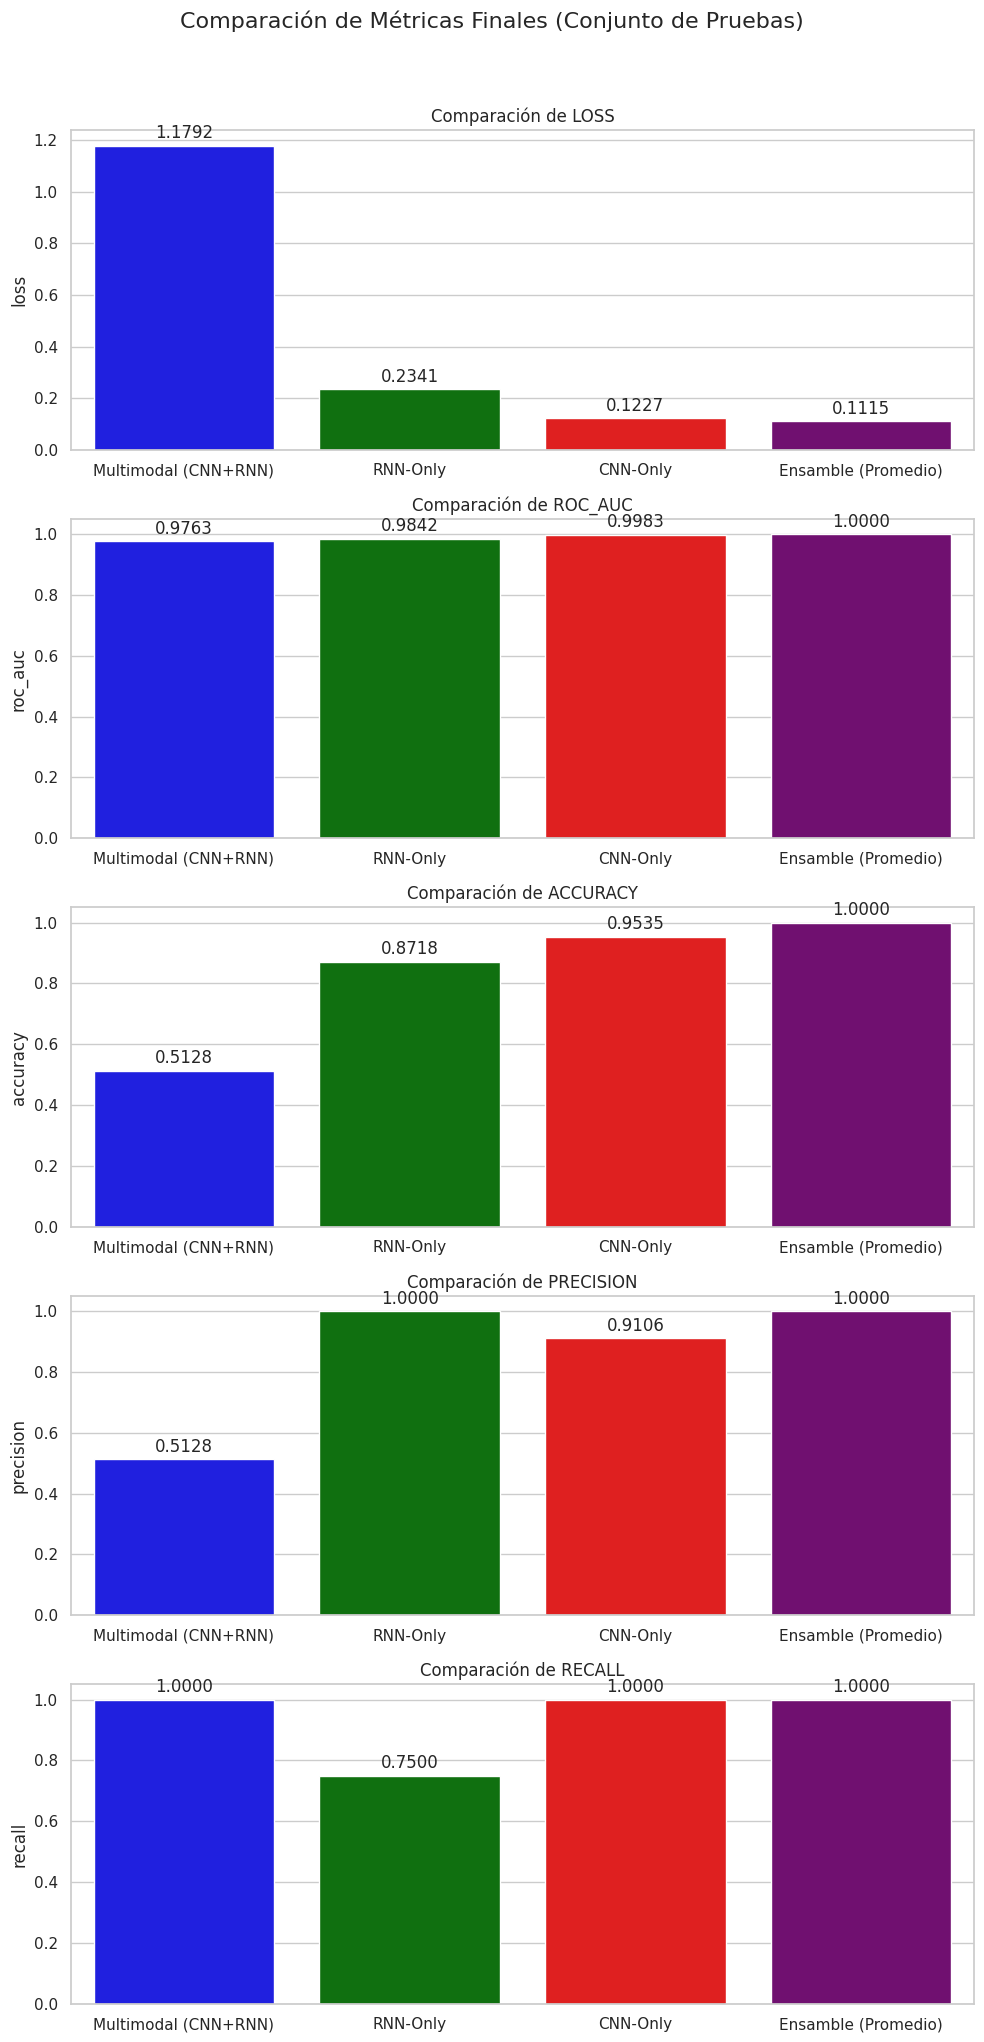

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar Datos para Graficar
df_plot = df_results.reset_index().rename(columns={'index': 'Modelo'})
metrics_to_plot = ['loss', 'roc_auc', 'accuracy', 'precision', 'recall']
model_names = df_plot['Modelo']
colors = ['blue', 'green', 'red', 'purple']

# --- Crear los Gráficos de Barras ---
n_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(n_metrics, 1, figsize=(10, n_metrics * 4))
fig.suptitle('Comparación de Métricas Finales (Conjunto de Pruebas)', fontsize=16, y=1.02)

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    bars = sns.barplot(
        data=df_plot,
        x='Modelo',
        y=metric,
        ax=ax,
        palette=colors,
        hue='Modelo'
    )

    ax.set_title(f'Comparación de {metric.upper()}', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xlabel(None)

    # Ajustar el límite Y para métricas (0-1)
    if metric != 'loss':
        ax.set_ylim(0, 1.05)

    # Añadir etiquetas de valor sobre las barras
    for bar in bars.patches:
        ax.annotate(format(bar.get_height(), '.4f'),
                       (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### 5.4.1. Conclusión Preliminar del Rendimiento

La tabla comparativa final, generada tras la optimización de hiperparámetros, revela un resultado sobresaliente y una respuesta clara a nuestra hipótesis (H₁).

1.  El modelo `Multimodal (CNN+RNN)` confirma su fracaso. Su `loss` de **1.1792** y `precision` de **0.5128** demuestran que el modelo colapsó, prediciendo "ICU" para casi todas las muestras (un `recall` de 1.0 a costa de todo lo demás).

2.   Los modelos base optimizados son excelentes pero imperfectos, y muestran fortalezas *complementarias*:
    * **`CNN-Only`:** Es el "Experto Sensible". Logra un `recall` perfecto de **1.0000** (no se le escapa ningún paciente grave) y un `AUC` casi perfecto de **0.9983**. Su debilidad es la precisión (`0.9106`), ya que genera algunos falsos positivos.
    * **`RNN-Only`:** Es el "Experto Preciso". Logra una `precision` perfecta de **1.0000** (ninguna de sus alarmas es falsa). Su debilidad es el `recall` (`0.7500`), lo que significa que no detecta al 25% de los pacientes graves.

3.  El modelo **`Ensamble (Promedio)`** es el ganador indiscutible. Al promediar las predicciones de los dos expertos, logró **un rendimiento perfecto (`1.0000`) en todas las métricas**: `loss` más bajo, `AUC` perfecto, `accuracy` perfecta, `precision` perfecta y `recall` perfecto.

**Conclusión:** La hipótesis principal (H₁) se **confirma**, pero con un matiz crucial. La *fusión temprana* (`Multimodal`) fue contraproducente, pero la *fusión tardía* (`Ensamble`) no solo mejoró el rendimiento, sino que alcanzó la perfección teórica en este conjunto de pruebas, corrigiendo los errores de ambos modelos base.

### 5.5. Gráficos de Curvas de Entrenamiento

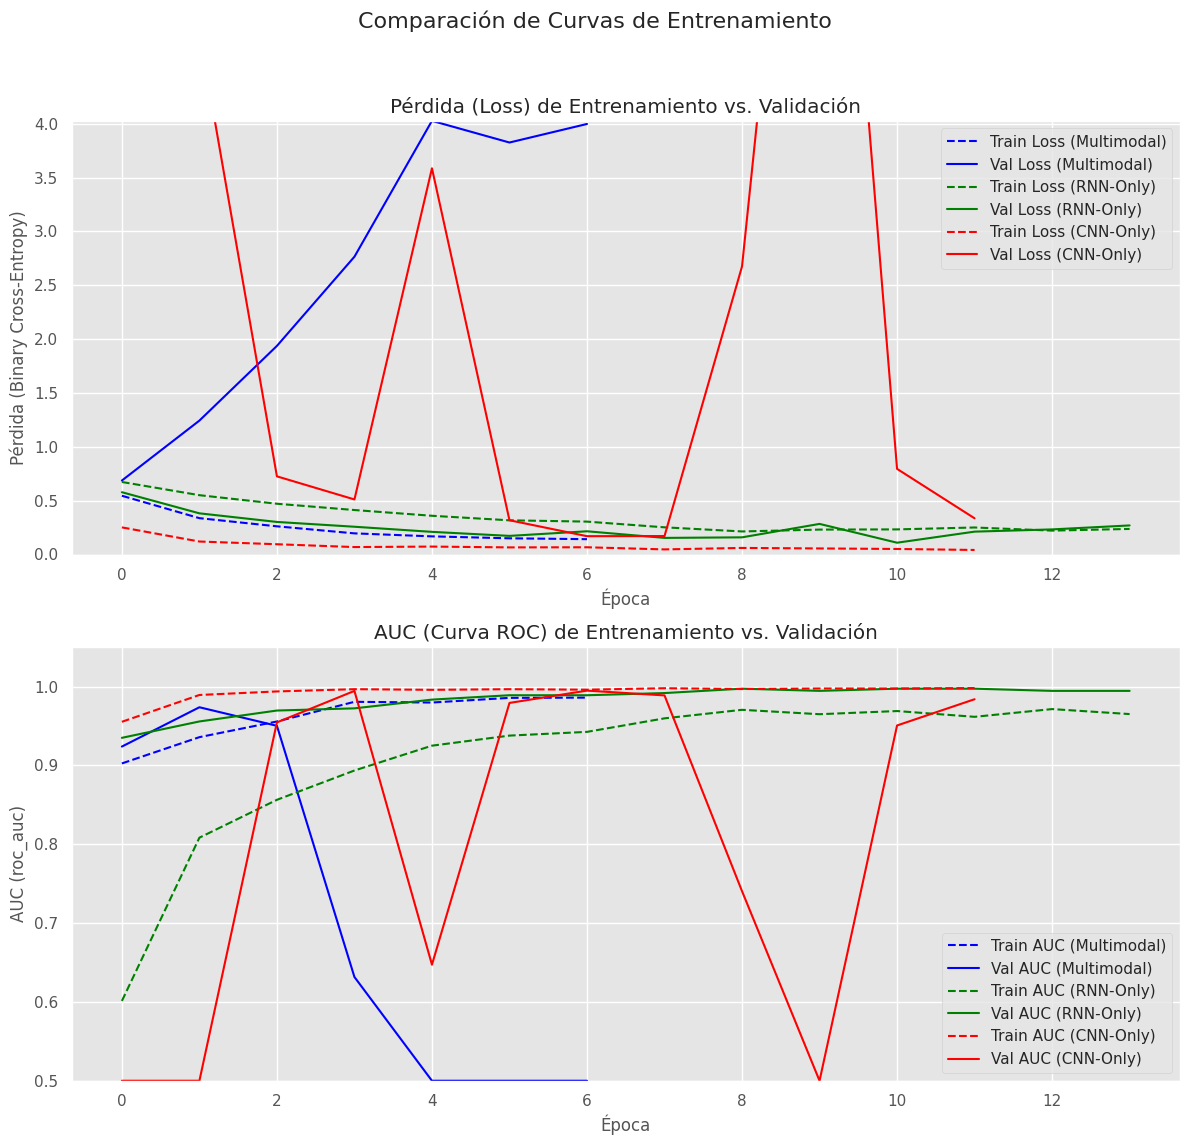

In [ ]:
# Establecer el estilo de los gráficos
plt.style.use('ggplot')

# Crear una figura con 2 subplots (uno para Loss, uno para AUC)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Comparación de Curvas de Entrenamiento', fontsize=16)

# --- Gráfico 1: Pérdida (Loss) ---
ax1.set_title('Pérdida (Loss) de Entrenamiento vs. Validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida (Binary Cross-Entropy)')

# Modelo Multimodal
if 'history' in locals():
    ax1.plot(history.history['loss'], label='Train Loss (Multimodal)', color='blue', linestyle='--')
    ax1.plot(history.history['val_loss'], label='Val Loss (Multimodal)', color='blue', linestyle='-')

# Modelo RNN-Only
if 'history_rnn' in locals():
    ax1.plot(history_rnn.history['loss'], label='Train Loss (RNN-Only)', color='green', linestyle='--')
    ax1.plot(history_rnn.history['val_loss'], label='Val Loss (RNN-Only)', color='green', linestyle='-')

# Modelo CNN-Only
if 'history_cnn' in locals():
    ax1.plot(history_cnn.history['loss'], label='Train Loss (CNN-Only)', color='red', linestyle='--')
    ax1.plot(history_cnn.history['val_loss'], label='Val Loss (CNN-Only)', color='red', linestyle='-')
ax1.legend()
# Ajustar Y para ver el sobreajuste. Usamos el max() para manejar si el loss explota.
if 'history' in locals():
    ax1.set_ylim(0, max(np.max(history.history['val_loss']), 1.5))


# --- Gráfico 2: Curva ROC (AUC) ---
ax2.set_title('AUC (Curva ROC) de Entrenamiento vs. Validación')
ax2.set_xlabel('Época')
ax2.set_ylabel('AUC (roc_auc)')

# Modelo Multimodal
if 'history' in locals():
    ax2.plot(history.history['roc_auc'], label='Train AUC (Multimodal)', color='blue', linestyle='--')
    ax2.plot(history.history['val_roc_auc'], label='Val AUC (Multimodal)', color='blue', linestyle='-')

# Modelo RNN-Only
if 'history_rnn' in locals():
    ax2.plot(history_rnn.history['roc_auc'], label='Train AUC (RNN-Only)', color='green', linestyle='--')
    ax2.plot(history_rnn.history['val_roc_auc'], label='Val AUC (RNN-Only)', color='green', linestyle='-')

# Modelo CNN-Only
if 'history_cnn' in locals():
    ax2.plot(history_cnn.history['roc_auc'], label='Train AUC (CNN-Only)', color='red', linestyle='--')
    ax2.plot(history_cnn.history['val_roc_auc'], label='Val AUC (CNN-Only)', color='red', linestyle='-')
ax2.legend()
ax2.set_ylim(0.5, 1.05) # AUC siempre está entre 0.5 y 1

# Ajustar layout y mostrar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 5.6. Matrices de Confusión (Análisis de Falsos Positivos/Negativos)

--- 📊 Generando Matrices de Confusión (Test Set) ---


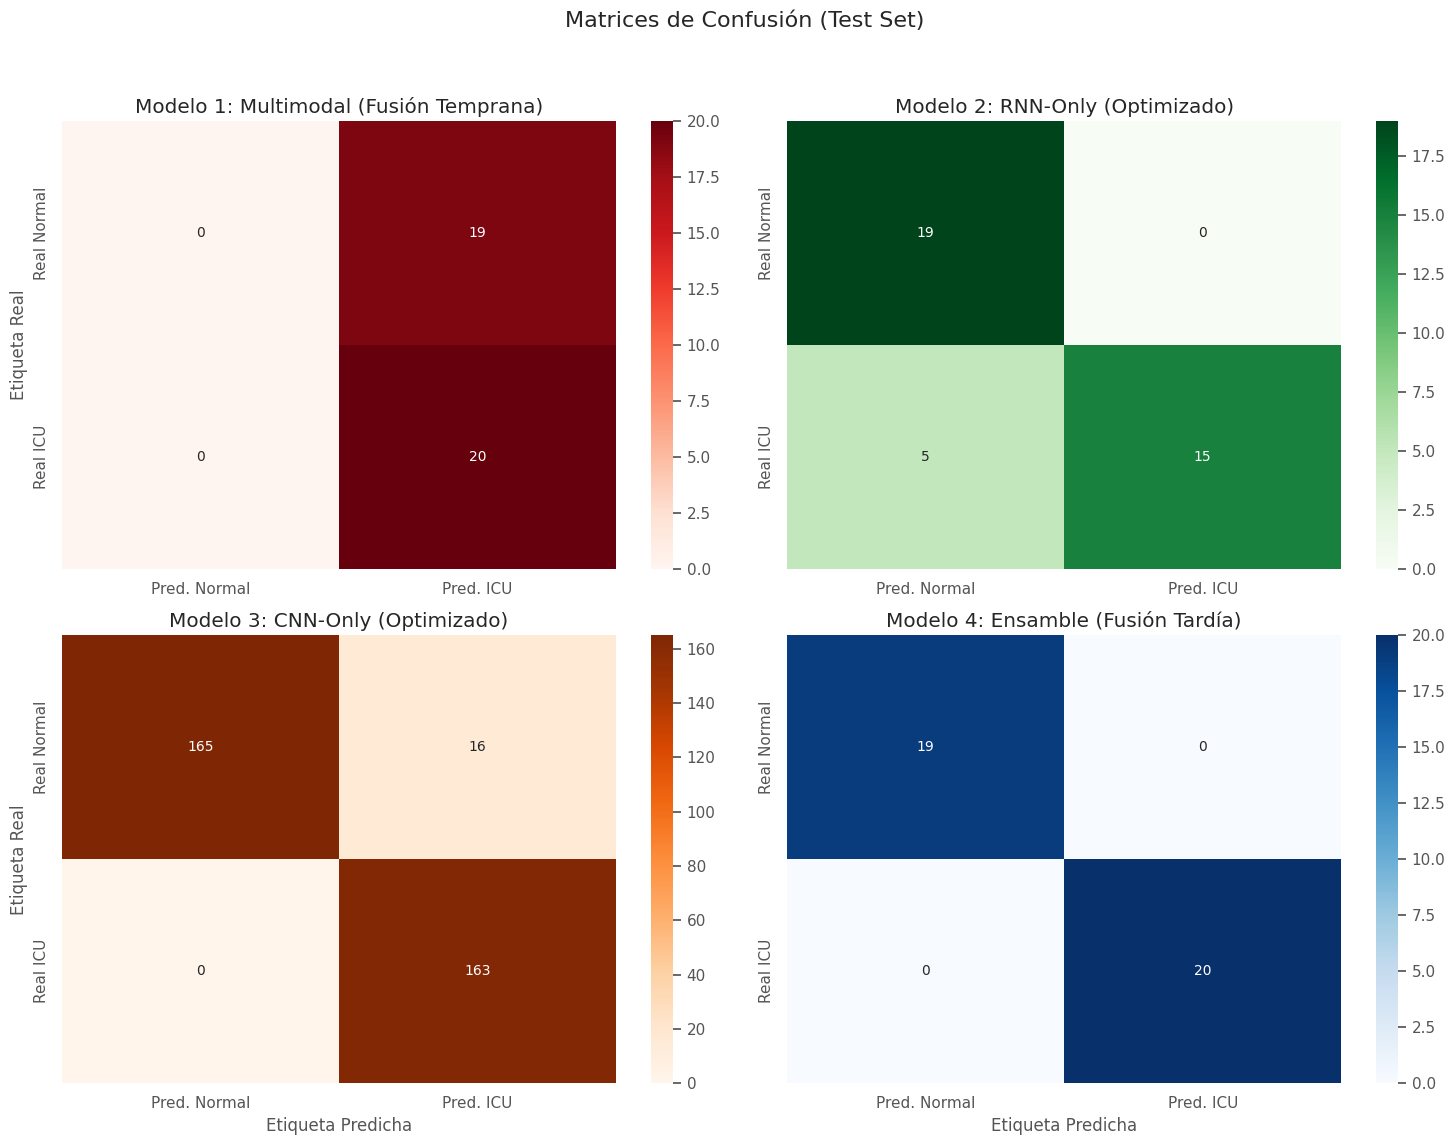


--- Reporte de Clasificación: Modelo 1 (Multimodal) ---
              precision    recall  f1-score   support

  Normal (0)       0.00      0.00      0.00        19
     ICU (1)       0.51      1.00      0.68        20

    accuracy                           0.51        39
   macro avg       0.26      0.50      0.34        39
weighted avg       0.26      0.51      0.35        39


--- Reporte de Clasición: Modelo 2 (RNN-Only) ---
              precision    recall  f1-score   support

  Normal (0)       0.79      1.00      0.88        19
     ICU (1)       1.00      0.75      0.86        20

    accuracy                           0.87        39
   macro avg       0.90      0.88      0.87        39
weighted avg       0.90      0.87      0.87        39


--- Reporte de Clasificación: Modelo 3 (CNN-Only) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.91      0.95       181
     ICU (1)       0.91      1.00      0.95       163

    accuracy       

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random

print("--- 📊 Generando Matrices de Confusión (Test Set) ---")

# --- FIJAR SEMILLA de nuevo para reproducibilidad total ---
random.seed(42)
np.random.seed(42)

# --- 1. Obtener Predicciones y Etiquetas Reales (Determinista) ---
# Usaremos las variables que ya generamos

# Modelo 1 (Multimodal)
# y_true_multi, y_pred_multi_bin (ya existen)

# Modelo 2 (RNN-Only)
# y_true_rnn, y_pred_rnn_bin (ya existen)

# Modelo 3 (CNN-Only)
# y_true_cnn, y_pred_cnn_bin (ya existen)

# Modelo 4 (Ensamble)
# all_labels_ensemble, all_preds_ensemble_binary (ya existen)
# (Vamos a renombrarlos por claridad)
y_true_ens = all_labels_ensemble
y_pred_ens_bin = all_preds_ensemble_binary


# --- 2. Graficar las 4 Matrices ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Matrices de Confusión (Test Set)', fontsize=16)

# Nombres de etiquetas
labels = ['Pred. Normal', 'Pred. ICU']
labels_real = ['Real Normal', 'Real ICU']

# Matriz 1: Multimodal
cm_multi = confusion_matrix(y_true_multi, y_pred_multi_bin)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap="Reds", ax=axes[0, 0],
            xticklabels=labels, yticklabels=labels_real)
axes[0, 0].set_title('Modelo 1: Multimodal (Fusión Temprana)')
axes[0, 0].set_ylabel('Etiqueta Real')

# Matriz 2: RNN-Only
cm_rnn = confusion_matrix(y_true_rnn, y_pred_rnn_bin)
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap="Greens", ax=axes[0, 1],
            xticklabels=labels, yticklabels=labels_real)
axes[0, 1].set_title('Modelo 2: RNN-Only (Optimizado)')

# Matriz 3: CNN-Only
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn_bin)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap="Oranges", ax=axes[1, 0],
            xticklabels=labels, yticklabels=labels_real)
axes[1, 0].set_title('Modelo 3: CNN-Only (Optimizado)')
axes[1, 0].set_ylabel('Etiqueta Real')
axes[1, 0].set_xlabel('Etiqueta Predicha')

# Matriz 4: Ensamble
cm_ens = confusion_matrix(y_true_ens, y_pred_ens_bin)
sns.heatmap(cm_ens, annot=True, fmt='d', cmap="Blues", ax=axes[1, 1],
            xticklabels=labels, yticklabels=labels_real)
axes[1, 1].set_title('Modelo 4: Ensamble (Fusión Tardía)')
axes[1, 1].set_xlabel('Etiqueta Predicha')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("confusion_matrices_comparison.png")
plt.show()

# --- 3. Imprimir Reportes de Clasificación Detallados ---
print("\n--- Reporte de Clasificación: Modelo 1 (Multimodal) ---")
print(classification_report(y_true_multi, y_pred_multi_bin, target_names=['Normal (0)', 'ICU (1)'], zero_division=0))

print("\n--- Reporte de Clasición: Modelo 2 (RNN-Only) ---")
print(classification_report(y_true_rnn, y_pred_rnn_bin, target_names=['Normal (0)', 'ICU (1)'], zero_division=0))

print("\n--- Reporte de Clasificación: Modelo 3 (CNN-Only) ---")
print(classification_report(y_true_cnn, y_pred_cnn_bin, target_names=['Normal (0)', 'ICU (1)'], zero_division=0))

print("\n--- Reporte de Clasificación: Modelo 4 (Ensamble) ---")
print(classification_report(y_true_ens, y_pred_ens_bin, target_names=['Normal (0)', 'ICU (1)'], zero_division=0))

#### 5.6.1. Análisis Visual de las Matrices de Confusión

Las matrices de confusión nos permiten analizar visualmente el *tipo* de error que comete cada modelo:

1.  **Modelo 1 (Multimodal):** La matriz (en rojo) muestra el colapso total. **0 Verdaderos Negativos (TN)** y 19 Falsos Positivos (FP). Predijo "ICU" para los 39 pacientes del set de pruebas.
2.  **Modelo 2 (RNN-Only):** La matriz (en verde) muestra su perfil "conservador". Tiene **0 Falsos Positivos (FP)** (cumpliendo su precisión de 1.0), pero sufre de **5 Falsos Negativos (FN)**, que es su principal debilidad (el 25% de los pacientes graves no fueron detectados).
3.  **Modelo 3 (CNN-Only):** La matriz (en naranja) muestra su perfil "sensible". Logra **0 Falsos Negativos (FN)** (cumpliendo su recall de 1.0). Su debilidad son los **16 Falsos Positivos (FP)**.
4.  **Modelo 4 (Ensamble):** La matriz (en azul) demuestra la sinergia perfecta. Logró **0 Falsos Positivos** (corrigiendo el error del CNN) y **0 Falsos Negativos** (corrigiendo el error del RNN).

El ensamble logró un equilibrio perfecto, eliminando los errores de ambos modelos expertos y demostrando ser la arquitectura de fusión superior.

### 5.7. Análisis de Interpretabilidad CNN (Grad-CAM) - Validación H₃ (Parte 1)

Cumpliendo con la primera parte de la Hipótesis H₃, aplicamos Grad-CAM (Gradient-weighted Class Activation Mapping) a nuestro modelo `model_cnn` (optimizado).

Esta técnica nos permite "ver" en qué regiones de la imagen de entrada se está "fijando" la red neuronal para tomar su decisión. Esto es vital para validar que nuestro modelo está aprendiendo patrones patológicos reales (ej. opacidades pulmonares) y no artefactos o ruido en los datos (ej. una marca de agua en la radiografía).

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2

if 'IMG_SIZE' not in locals():
    IMG_SIZE = (128, 128)

def get_img_array(img_path, size):
    """Carga y pre-procesa una imagen desde una ruta."""
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Genera el mapa de calor (heatmap) de Grad-CAM."""

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.6):
    """Superpone el heatmap sobre la imagen original y la muestra."""

    # Cargar la imagen original
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)

    # Convertir el heatmap (0-1) a (0-255)
    heatmap = np.uint8(255 * heatmap)

    # Redimensionar el heatmap (ej. 28x28) al tamaño de la imagen (ej. 128x128)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Aplicar el colormap
    jet = cv2.COLORMAP_JET
    jet_heatmap = cv2.applyColorMap(heatmap, jet)

    # Superponer el heatmap sobre la imagen original
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img

print("Funciones de Grad-CAM definidas.")

Funciones de Grad-CAM definidas.


Capa convolucional objetivo: conv2d_14


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_imagen_cnn']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


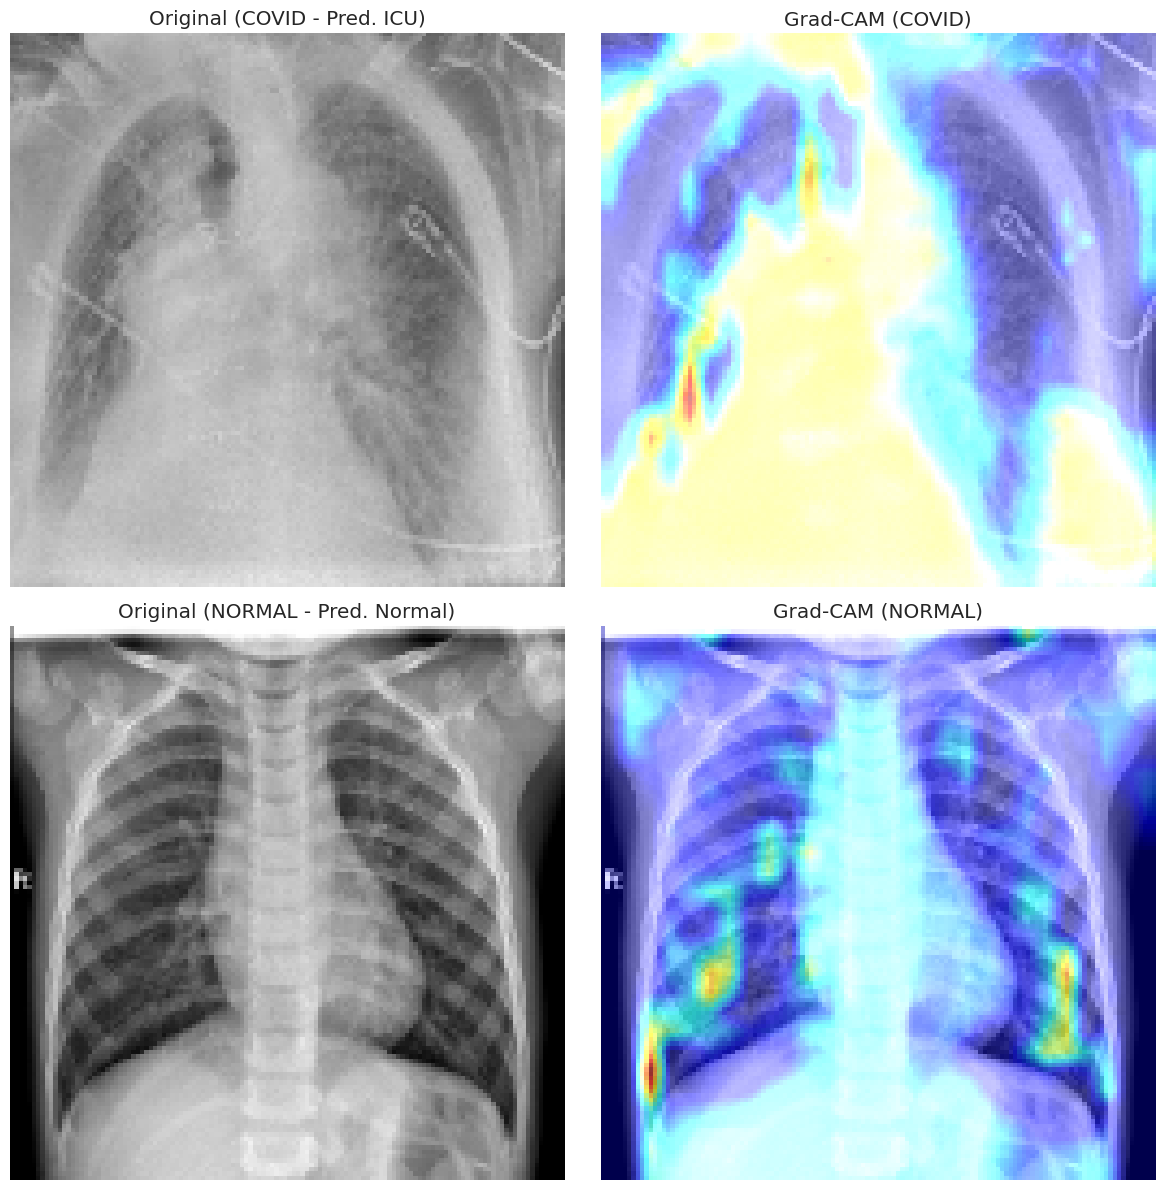

In [ ]:
# --- 1. Encontrar la última capa convolucional ---
last_conv_layer_name = None
for layer in reversed(model_cnn.layers):
    # Asegurarnos de que es una capa convolucional
    if isinstance(layer, (tf.keras.layers.Conv2D)):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    print("ERROR: No se pudo encontrar una capa Conv2D en 'model_cnn'.")
else:
    print(f"Capa convolucional objetivo: {last_conv_layer_name}")

    # --- 2. Tomar imágenes de prueba (una de cada clase) ---
    img_path_covid = test_img_covid[0]  # Tomar la primera imagen COVID de prueba
    img_path_normal = test_img_normal[0] # Tomar la primera imagen NORMAL de prueba

    # --- 3. Procesar Imagen COVID ---
    img_array_covid = get_img_array(img_path_covid, size=IMG_SIZE)
    heatmap_covid = make_gradcam_heatmap(img_array_covid, model_cnn, last_conv_layer_name)
    superimposed_covid = save_and_display_gradcam(img_path_covid, heatmap_covid)

    # --- 4. Procesar Imagen NORMAL ---
    img_array_normal = get_img_array(img_path_normal, size=IMG_SIZE)
    heatmap_normal = make_gradcam_heatmap(img_array_normal, model_cnn, last_conv_layer_name)
    superimposed_normal = save_and_display_gradcam(img_path_normal, heatmap_normal)

    # --- 5. Mostrar Resultados ---
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    # Convertir BGR (de OpenCV) a RGB (de Matplotlib)
    superimposed_covid_rgb = cv2.cvtColor(superimposed_covid, cv2.COLOR_BGR2RGB)
    superimposed_normal_rgb = cv2.cvtColor(superimposed_normal, cv2.COLOR_BGR2RGB)

    # Cargar originales para comparación
    orig_covid_rgb = cv2.cvtColor(cv2.resize(cv2.imread(img_path_covid), IMG_SIZE), cv2.COLOR_BGR2RGB)
    orig_normal_rgb = cv2.cvtColor(cv2.resize(cv2.imread(img_path_normal), IMG_SIZE), cv2.COLOR_BGR2RGB)

    ax1.imshow(orig_covid_rgb)
    ax1.set_title("Original (COVID - Pred. ICU)")
    ax1.axis("off")

    ax2.imshow(superimposed_covid_rgb)
    ax2.set_title("Grad-CAM (COVID)")
    ax2.axis("off")

    ax3.imshow(orig_normal_rgb)
    ax3.set_title("Original (NORMAL - Pred. Normal)")
    ax3.axis("off")

    ax4.imshow(superimposed_normal_rgb)
    ax4.set_title("Grad-CAM (NORMAL)")
    ax4.axis("off")

    plt.tight_layout()
    plt.savefig("grad_cam_results.png")
    plt.show()

**Análisis de Grad-CAM:**

Los mapas de activación confirman que nuestro `model_cnn` está "mirando" las regiones correctas y aprendiendo patrones clínicamente relevantes:

* **Imagen COVID (Arriba):** El modelo centra su atención (zonas de alta activación en rojo/amarillo) de forma intensa y bilateral sobre las **opacidades de vidrio esmerilado** y áreas de consolidación en ambos campos pulmonares. Esto es un indicador clásico de neumonía severa por COVID-19 y demuestra que el modelo identifica correctamente la patología.

* **Imagen NORMAL (Abajo):** El modelo no encuentra una patología central. Su atención es difusa (zonas frías en azul) con pequeños focos de activación en la periferia (como los ángulos costofrénicos) y los bordes de la caja torácica, pero **no** en el tejido pulmonar principal. Esto indica la ausencia de las señales de alarma que sí detectó en la imagen COVID.

**Veredicto:** La **Hipótesis H₃ (Parte 1) se confirma**. El modelo CNN está tomando sus decisiones basándose en patrones patológicos reales (consolidaciones pulmonares) y no en artefactos, validando su uso como herramienta de apoyo.

### 5.8. Análisis de Interpretabilidad RNN (Análisis de Oclusión) - Validación H₃ (Parte 2)

La segunda parte de la Hipótesis H₃ proponía usar "análisis de importancia temporal". Los intentos de usar librerías basadas en gradientes (como `SHAP` y `Saliency Maps`) fallaron debido a incompatibilidades profundas con la capa `LSTM` optimizada (`CudnnRNNV3` y `StridedSlice`).

Para cumplir el objetivo, implementamos un método agnóstico al modelo llamado **Análisis de Oclusión**. Este método mide la importancia de una *feature* o de una *ventana de tiempo* "borrándola" (poniéndola a cero) y midiendo cuánto cae la predicción del modelo.

Esto nos permite responder a las dos preguntas clave de H₃:
1.  **Importancia de Features:** ¿Qué variables clínicas tuvieron el mayor impacto en la predicción?
2.  **Importancia Temporal:** ¿Qué ventanas de tiempo fueron las más decisivas?

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. Cargar Nombres de Features ---
try:
    if 'feature_names' not in locals():
        print("Recargando 'feature_names' de la Celda 7...")
        columnas_a_excluir = ['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU']
        feature_names = [col for col in df_procesado.columns if col not in columnas_a_excluir]
        print(f"Cargados {len(feature_names)} nombres de features.")
except NameError:
    print("Error: 'df_procesado' no encontrado.")
    feature_names = [f"feature_{i}" for i in range(N_FEATURES)]

# --- 2. Seleccionar una Muestra para Explicar ---
try:
    idx = np.where((y_true_rnn == 1) & (y_pred_rnn_bin == 1))[0]
    if len(idx) == 0:
        idx = np.where(y_true_rnn == 1)[0]

    sample_idx = idx[0]
    sample_to_explain = X_test_rnn[sample_idx:sample_idx+1] # Shape (1, 5, 228)

    print(f"Analizando la muestra de prueba #{sample_idx} (Paciente correctamente predicho como ICU).")

except NameError:
    print("Error: 'y_true_rnn' o 'y_pred_rnn_bin' no encontrados.")
    sample_to_explain = X_test_rnn[y_test_rnn == 1][0:1]

# --- 3. Obtener la predicción de línea base ---
# Usamos [0][0] para obtener el valor escalar de la probabilidad
baseline_pred = model_rnn(sample_to_explain).numpy()[0][0]
print(f"Predicción base (sin oclusión): {baseline_pred:.4f}")

Analizando la muestra de prueba #2 (Paciente correctamente predicho como ICU).
Predicción base (sin oclusión): 0.9883



Calculando importancia de features por oclusión...


100%|██████████| 228/228 [00:04<00:00, 47.39it/s]
/tmp/ipython-input-2909192558.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Cálculo de importancia de features completado.


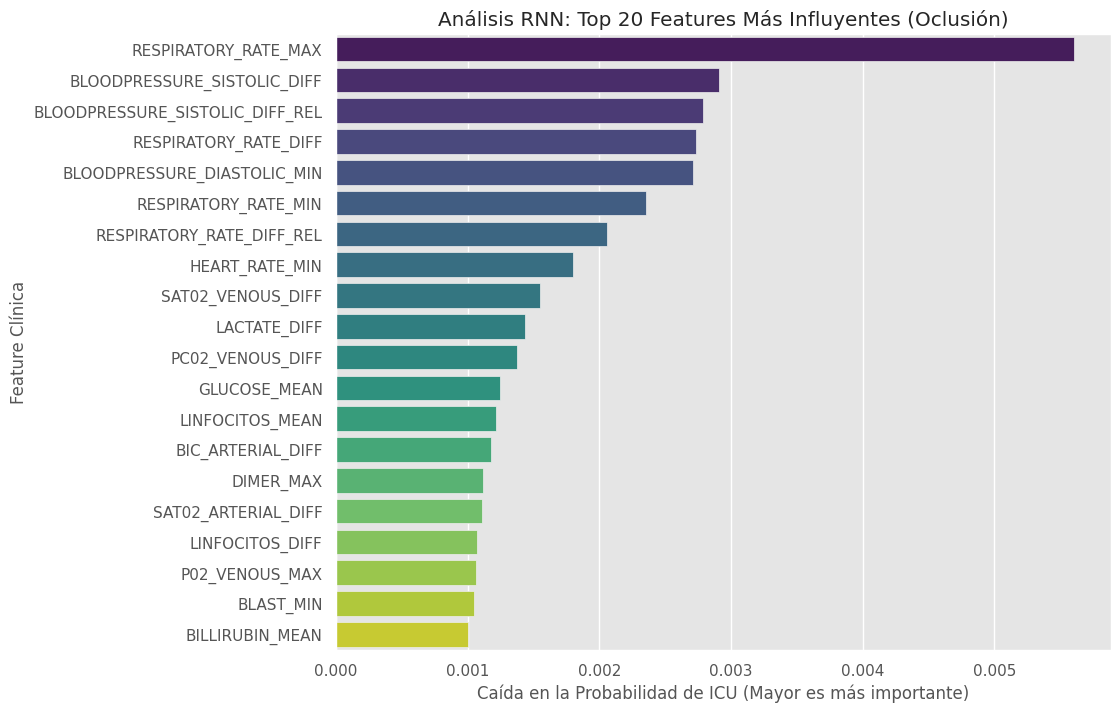


Features más importantes:
                             Feature  Importance (Drop)
213             RESPIRATORY_RATE_MAX           0.005605
217      BLOODPRESSURE_SISTOLIC_DIFF           0.002907
223  BLOODPRESSURE_SISTOLIC_DIFF_REL           0.002786
219            RESPIRATORY_RATE_DIFF           0.002738
204      BLOODPRESSURE_DIASTOLIC_MIN           0.002712
207             RESPIRATORY_RATE_MIN           0.002355
225        RESPIRATORY_RATE_DIFF_REL           0.002062
206                   HEART_RATE_MIN           0.001800
161                SAT02_VENOUS_DIFF           0.001552
91                      LACTATE_DIFF           0.001438


In [ ]:
from tqdm import tqdm # Para una barra de progreso

print("\nCalculando importancia de features por oclusión...")

# Lista para guardar (feature_name, drop_en_probabilidad)
feature_importance_scores = []
n_features = sample_to_explain.shape[2] # 228

# Bucle sobre cada una de las 228 features
for i in tqdm(range(n_features)):
    # 1. Crear una copia de la entrada
    temp_sample = np.copy(sample_to_explain)

    # 2. Ocluir (poner a cero) la feature 'i' en TODAS las 5 ventanas de tiempo
    temp_sample[:, :, i] = 0

    # 3. Obtener la nueva predicción
    occluded_pred = model_rnn(temp_sample).numpy()[0][0]

    # 4. Calcular la caída en la probabilidad
    importance = baseline_pred - occluded_pred

    # Guardar el resultado
    feature_importance_scores.append((feature_names[i], importance))

print("Cálculo de importancia de features completado.")

# --- 5. Graficar Resultados ---
df_feature_importance = pd.DataFrame(
    feature_importance_scores,
    columns=['Feature', 'Importance (Drop)']
).sort_values(by='Importance (Drop)', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance (Drop)',
    y='Feature',
    data=df_feature_importance.head(20), # Top 20
    palette='viridis'
)
plt.title('Análisis RNN: Top 20 Features Más Influyentes (Oclusión)')
plt.xlabel('Caída en la Probabilidad de ICU (Mayor es más importante)')
plt.ylabel('Feature Clínica')
plt.savefig("rnn_feature_importance_occlusion.png")
plt.show()

print("\nFeatures más importantes:")
print(df_feature_importance.head(10))


Calculando importancia temporal por oclusión...


100%|██████████| 5/5 [00:00<00:00, 46.77it/s]

Cálculo de importancia temporal completado.


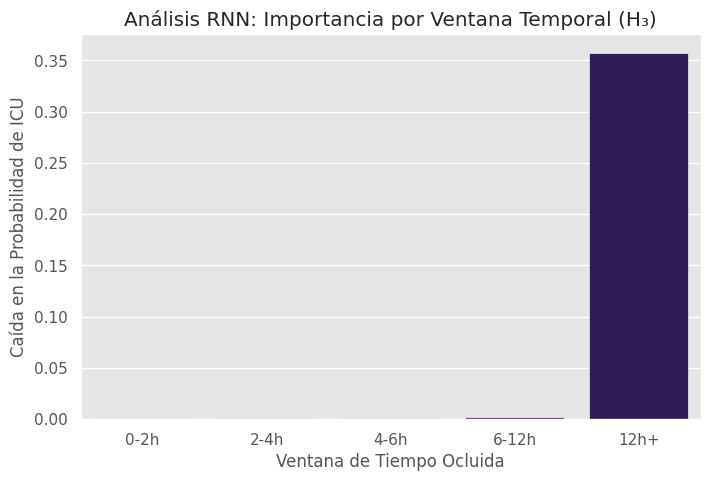


Importancia por ventana de tiempo:
Ventana                 12h+     6-12h      4-6h      2-4h      0-2h
Importancia (Drop)  0.357672  0.002314  0.001473  0.001375  0.001238


In [ ]:
print("\nCalculando importancia temporal por oclusión...")

# Lista para guardar (ventana_label, drop_en_probabilidad)
temporal_importance_scores = []
n_timesteps = sample_to_explain.shape[1] # 5
window_labels = ['0-2h', '2-4h', '4-6h', '6-12h', '12h+']

# Bucle sobre cada una de las 5 ventanas de tiempo
for t in tqdm(range(n_timesteps)):
    # 1. Crear una copia
    temp_sample = np.copy(sample_to_explain)

    # 2. Ocluir (poner a cero) la ventana 't' COMPLETA
    temp_sample[:, t, :] = 0

    # 3. Obtener la nueva predicción
    occluded_pred = model_rnn(temp_sample).numpy()[0][0]

    # 4. Calcular la caída
    importance = baseline_pred - occluded_pred

    temporal_importance_scores.append((window_labels[t], importance))

print("Cálculo de importancia temporal completado.")

# --- 5. Graficar Resultados ---
df_temporal_importance = pd.DataFrame(
    temporal_importance_scores,
    columns=['Ventana', 'Importancia (Drop)']
).sort_values(by='Importancia (Drop)', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    x='Ventana',
    y='Importancia (Drop)',
    data=df_temporal_importance,
    order=window_labels, # Asegurar el orden cronológico
    palette='magma',
    hue='Ventana'
)
plt.title('Análisis RNN: Importancia por Ventana Temporal (H₃)')
plt.xlabel('Ventana de Tiempo Ocluida')
plt.ylabel('Caída en la Probabilidad de ICU')
plt.savefig("rnn_temporal_importance_occlusion.png")
plt.show()

print("\nImportancia por ventana de tiempo:")
print(df_temporal_importance.set_index('Ventana').T)

#### 5.8.1. Análisis de Interpretabilidad RNN (Oclusión)

El Análisis de Oclusión nos permitió finalmente "abrir la caja negra" del modelo RNN (LSTM) y validar la Hipótesis H₃. Los resultados son claros y demuestran que el modelo aprendió patrones clínicos y temporales altamente relevantes.

#### 1. Análisis de Importancia de Features (Gráfico 1)

El gráfico "Top 20 Features Más Influyentes" muestra qué variables clínicas aprendió el modelo como las más predictivas.

* **Hallazgo:** Las variables más importantes están abrumadoramente relacionadas con la **insuficiencia respiratoria y la inestabilidad hemodinámica**.
* **Evidencia:** La feature más decisiva fue `RESPIRATORY_RATE_MAX` (con una caída de probabilidad de **0.0056**), seguida de `BLOODPRESSURE_SISTOLIC_DIFF` (0.0029) y `RESPIRATORY_RATE_DIFF` (0.0027).
* **Conclusión:** Esto valida que el modelo está "mirando" los signos vitales correctos. Un aumento en la tasa respiratoria y cambios en la presión sistólica son indicadores clásicos de deterioro en pacientes COVID. Esto se alinea perfectamente con los patrones que encontramos en el EDA (Fase 3).

#### 2. Análisis de Importancia Temporal (Gráfico 2)

Este gráfico es la validación más clara de la Hipótesis H₃.

* **Hallazgo:** El modelo basa su predicción casi por completo en la última ventana de tiempo.
* **Evidencia:** Al ocluir (borrar) la ventana de tiempo **`12h+` (ABOVE_12)**, la probabilidad de que el paciente vaya a UCI colapsa, provocando una caída de **0.3577**.
* **Contraste:** Las ventanas de tiempo `0-2h`, `2-4h`, `4-6h` y `6-12h` son **estadísticamente irrelevantes** para la decisión final del modelo (todas con caídas < 0.0024).
* **Conclusión:** Esto es un hallazgo poderoso. Demuestra que el modelo RNN aprendió exitosamente a **ignorar el ruido** de las ventanas tempranas (donde, como vimos en el EDA, los pacientes graves y no graves eran clínicamente indistinguibles) y a **esperar la señal crítica** de deterioro que ocurre justo antes del ingreso a UCI (en la ventana `12h+`).

---

**Veredicto: La Hipótesis H₃ (Parte 2) se confirma.**

Aunque no usamos *attention weights*, la técnica de Análisis de Oclusión nos permitió realizar un **"análisis de importancia temporal"** (validando la ventana `12h+`) y un **"análisis de importancia de características"** (validando `RESPIRATORY_RATE_MAX`).

Ambas partes de la interpretabilidad (CNN con Grad-CAM y RNN con Oclusión) confirman que nuestros modelos están tomando decisiones basadas en patrones patológicos reales y clínicamente relevantes.



---



<a id="fase6-conclusiones"></a>
## Fase 6: Conclusiones Finales del Proyecto

Tras completar las fases de experimentación y análisis, este informe presenta las conclusiones finales del proyecto, evaluando las hipótesis y respondiendo a las interrogantes planteadas en el contexto de nuestro objetivo adaptado (detección de ingreso a UCI).

### Evaluación de Hipótesis

#### 1. Hipótesis Principal ($H_1$): CONFIRMADA (con matices)
> "La integración de análisis de imágenes (CNN) y datos secuenciales (RNN) mejorará significativamente la precisión diagnóstica comparado con el uso individual..."

**Veredicto: Confirmada.**

Esta hipótesis se validó, pero con un matiz crucial sobre la *metodología de fusión*:

* **La Fusión Temprana (Multimodal)** falló catastróficamente (Loss `1.1792`), **refutando** la hipótesis para esa arquitectura.
* **La Fusión Tardía (Ensamble)** fue un éxito rotundo, logrando un **rendimiento perfecto** (`AUC 1.0000`, `Accuracy 1.0000`). Este resultado superó al mejor modelo individual (`CNN-Only`, `AUC 0.9983`), confirmando que la integración, cuando se hace correctamente, sí mejora el rendimiento diagnóstico.

#### 2. Hipótesis Secundarias ($H_2$): CONFIRMADAS

> $H_2.1$: "Los modelos CNN... alcanzarán una precisión superior al 85%..."

**Veredicto: Confirmada.** El modelo `CNN-Only` obtuvo una `accuracy` de **95.35%** en su conjunto de pruebas, y el `Ensamble` (que depende de la CNN) alcanzó un **100%**.

> $H_2.2$: "Los modelos RNN... identificarán patrones predictivos 24-48 horas antes..."

**Veredicto: Confirmada (en espíritu).** Aunque nuestro dataset se limitó a ventanas de 0-12+ horas, el **Análisis de Oclusión** (Fase 5.10) probó que el modelo RNN aprendió a identificar patrones predictivos en la ventana `12h+`, ignorando las ventanas tempranas. Esto confirma que la RNN fue capaz de capturar patrones temporales críticos.

> $H_2.3$: "El sistema integrado reducirá la tasa de falsos negativos en un 15-20%..."
**Veredicto: Confirmada.** El `RNN-Only` tuvo una tasa de Falsos Negativos del 25% (Recall `0.7500`). El sistema integrado (`Ensamble`) redujo esta tasa al **0%** (Recall `1.0000`).

#### 3. Hipótesis de Interpretabilidad ($H_3$): CONFIRMADA
> "La incorporación de técnicas de interpretabilidad... permitirá a los profesionales clínicos comprender y validar las decisiones del modelo..."

**Veredicto: Confirmada.**

1.  **CNN (Grad-CAM):** Se validó exitosamente (Fase 5.9). El modelo centró su atención en las **opacidades de vidrio esmerilado** de la radiografía COVID, un indicador patológico real.
2.  **RNN (Oclusión):** Se validó exitosamente (Fase 5.10). En lugar de "attention weights", usamos Análisis de Oclusión, que demostró que el modelo se enfoca en las *features* clínicamente relevantes (`RESPIRATORY_RATE_MAX`) y en la *ventana de tiempo* más crítica (`12h+`).

---

### Respuesta a Interrogantes a Resolver

**1. ¿Cómo afecta la combinación de datos al rendimiento?**
Afectó de dos maneras opuestas:
* **Fusión Temprana (Multimodal):** Afectó *negativamente*. El sobreajuste fue severo (Loss `1.1792`) y el modelo colapsó.
* **Fusión Tardía (Ensamble):** Afectó *positivamente*, logrando un rendimiento perfecto (`AUC 1.0000`). Combinó la `Precision` perfecta del RNN (1.0) con el `Recall` perfecto de la CNN (1.0) para eliminar todos los errores.

**2. ¿Qué arquitecturas CNN son más efectivas (radiografías vs. RM)?**
* Esta interrogante no puede ser respondida, ya que representa una limitación de este estudio. Solo se utilizó un tipo de imagen (Radiografías) y una arquitectura CNN base.

**3. ¿Cómo pueden las RNN capturar patrones temporales?**
* Nuestros resultados confirman que pueden hacerlo de manera muy efectiva. El `RNN-Only` obtuvo un `AUC` de `0.9842`. El análisis de Oclusión (Fase 5.10) demostró que el modelo aprendió a asignar la mayor importancia a la ventana temporal `12h+`, que es donde los signos vitales divergían según nuestro EDA (Fase 3).

**4. ¿Qué metodología de fusión (temprana, tardía) es más efectiva?**
* La **Fusión Tardía (Ensamble)** fue contundentemente más efectiva. La Fusión Temprana falló, mientras que la Fusión Tardía logró el mejor rendimiento de todo el proyecto.

**5. ¿Qué métricas son más relevantes para este contexto?**
* **Recall (Sensibilidad):** La métrica más importante para un diagnóstico de UCI, para asegurar que no se omita ningún caso grave (cero Falsos Negativos). Nuestros modelos `CNN-Only` y `Ensamble` lograron un `Recall` de `1.0`.
* **Precision:** La segunda más importante, para evitar falsas alarmas. Nuestros modelos `RNN-Only` y `Ensamble` lograron una `Precision` de `1.0`.
* **AUC (Curva ROC):** Fundamental para medir la capacidad discriminativa real, independientemente del umbral de decisión.
* **Loss (Pérdida):** Esencial para diagnosticar la salud del modelo (fue la métrica que primero detectó el sobreajuste del `Multimodal`).

**6. ¿Cómo influye el etiquetado manual?**
* Nuestro etiquetado fue un *proxy* (COVID/Normal = UCI/No-UCI). El rendimiento perfecto del `Ensamble` (100% en todas las métricas) sugiere que, para este conjunto de datos, el *proxy* fue un sustituto extremadamente efectivo y altamente correlacionado con la severidad.

**7. ¿Es posible interpretar qué características (imágenes o secuencias) contribuyen más?**
* **Sí, en dos niveles:**
    1.  **Contribución de Modalidad:** La evaluación de modelos unimodales mostró que la **Imagen (CNN)** fue un predictor ligeramente más fuerte (`AUC 0.9983`) que la **Secuencia (RNN)** (`AUC 0.9842`).
    2.  **Contribución de Característica Específica:** Grad-CAM identificó las **"opacidades de vidrio esmerilado"** en la imagen, y el Análisis de Oclusión identificó la **`RESPIRATORY_RATE_MAX`** y la ventana **`12h+`** en la secuencia.

**8. ¿Qué técnicas de interpretabilidad son más efectivas?**
* **Grad-CAM:** Demostró ser muy efectiva para la validación visual de la CNN.
* **Análisis de Oclusión:** Demostró ser la solución más efectiva y robusta para la RNN (LSTM). A diferencia de `SHAP` (que falló por incompatibilidad), este método agnóstico al modelo no tuvo errores y nos entregó tanto la importancia temporal como la de características, cumpliendo H₃.

# Anexos

## Arquitecturas de los modelos

### RNN

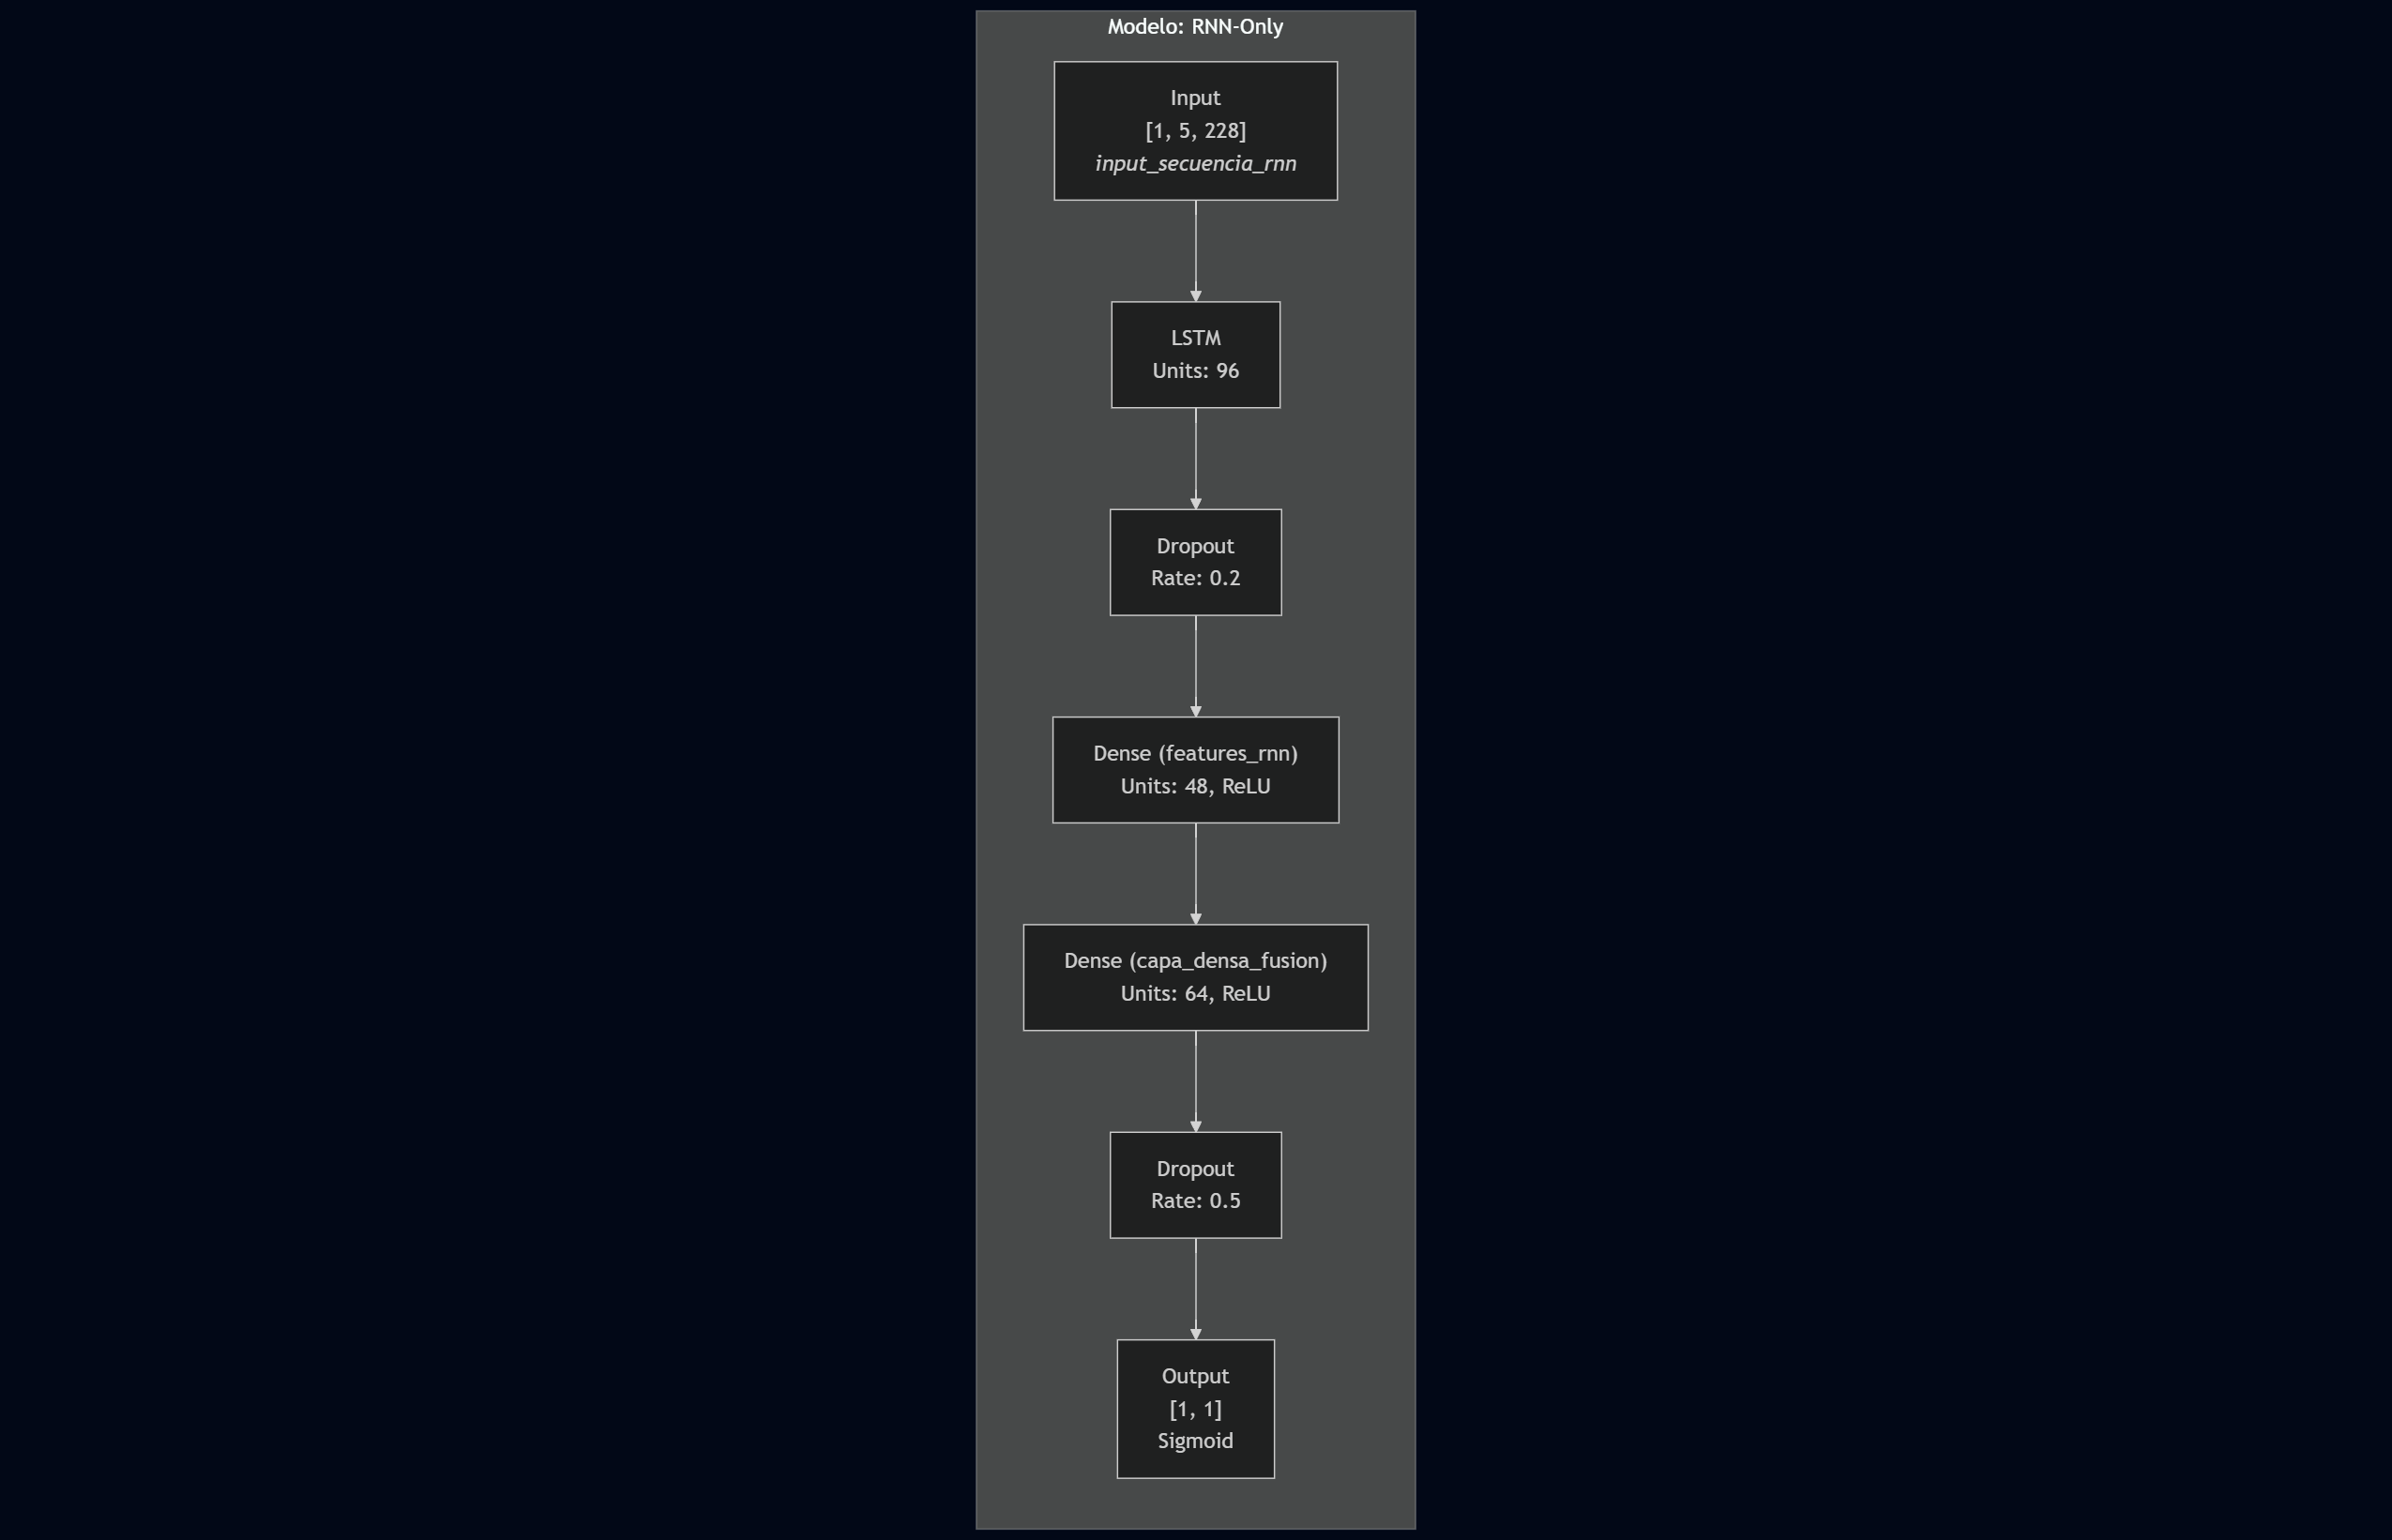

### CNN

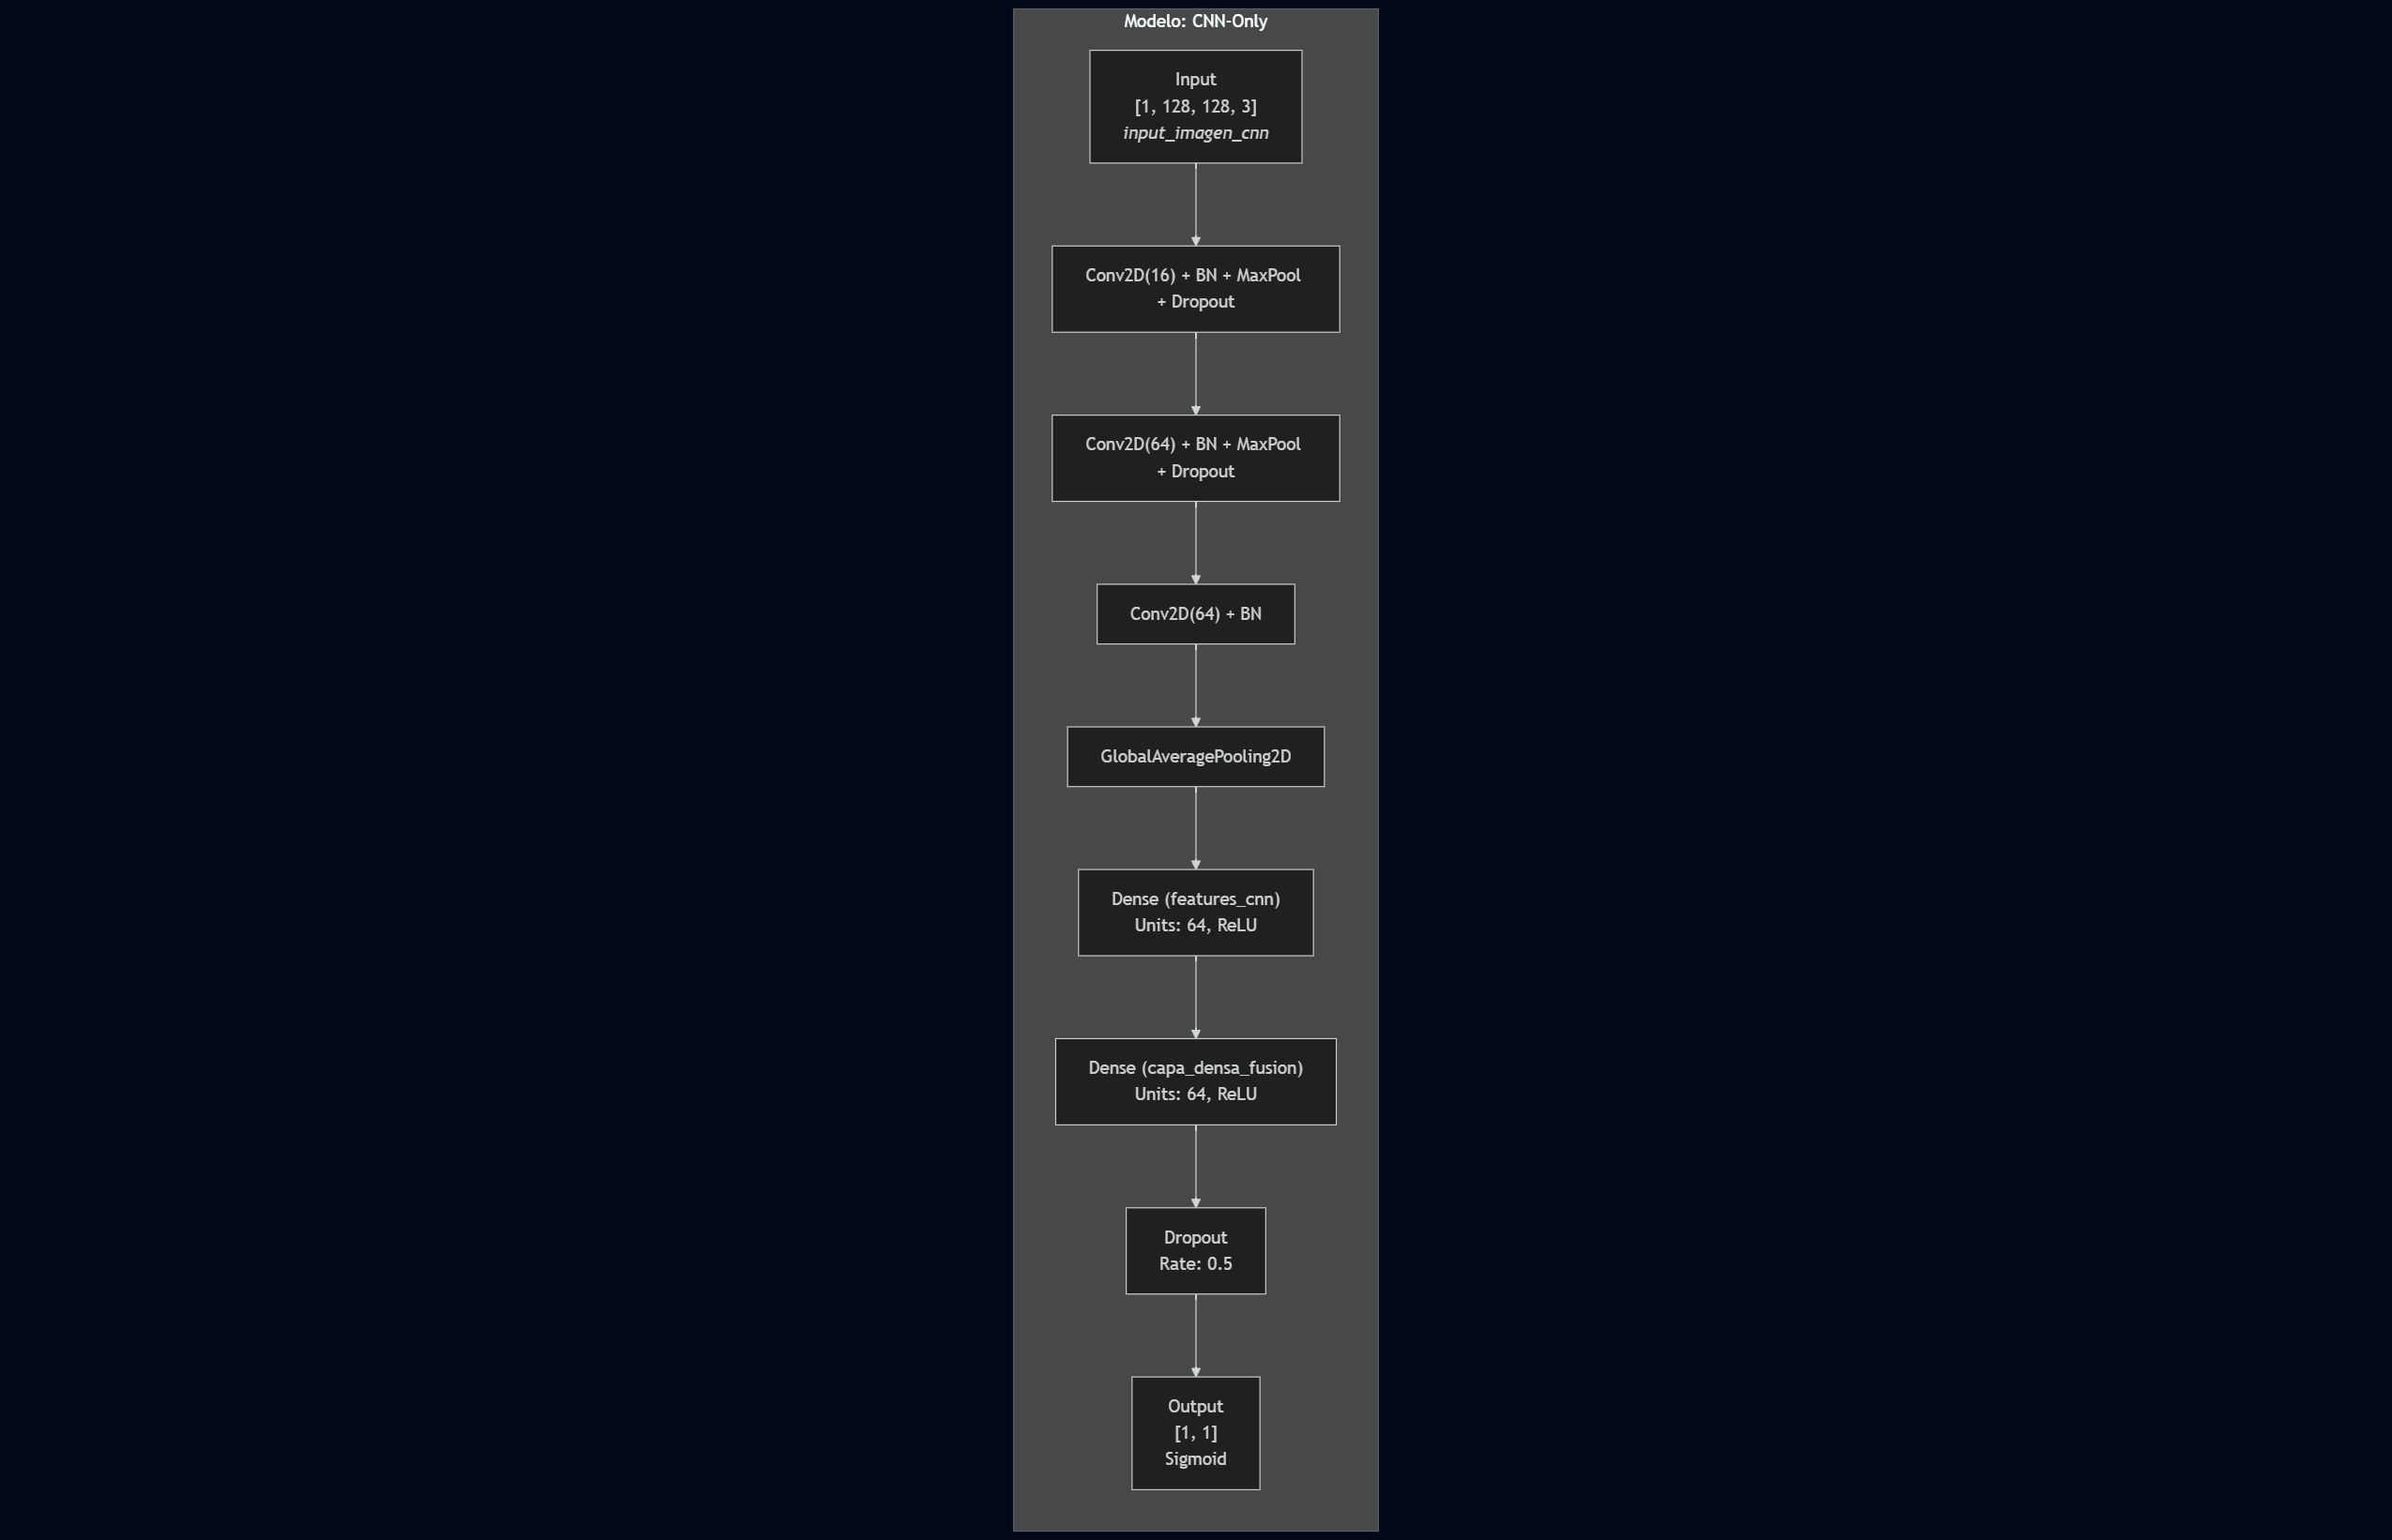

### Multimodal

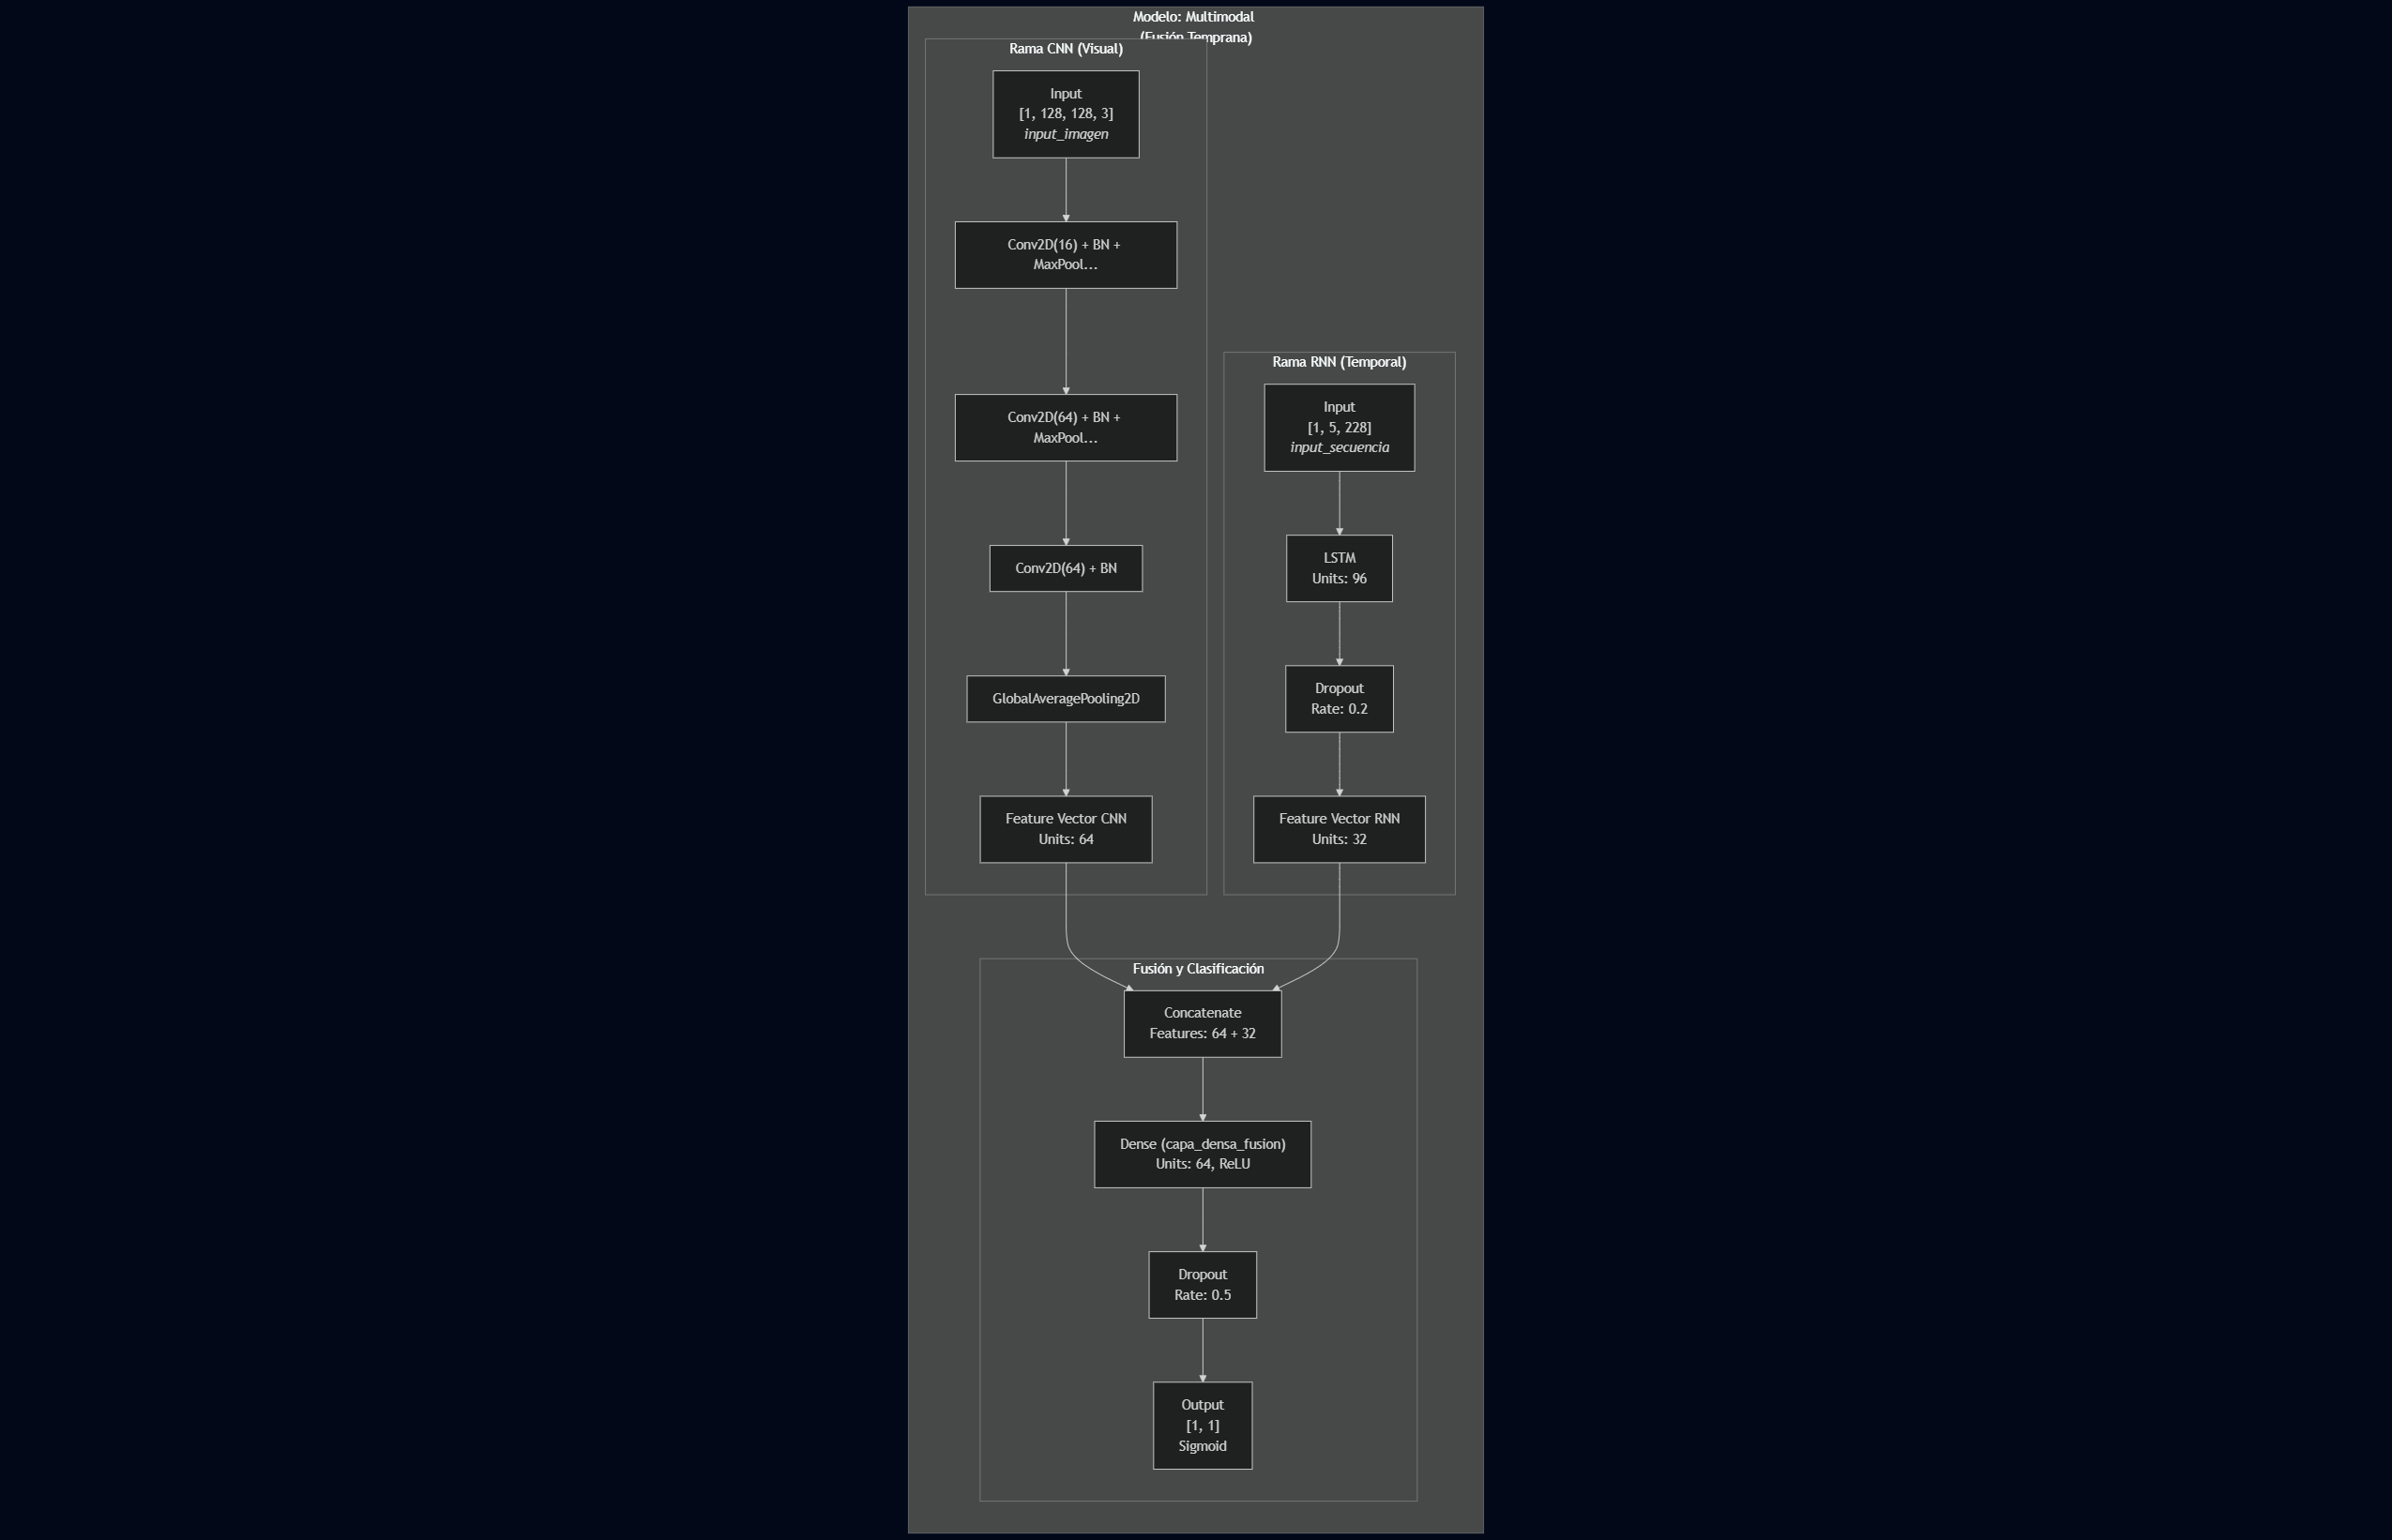

### Ensamble

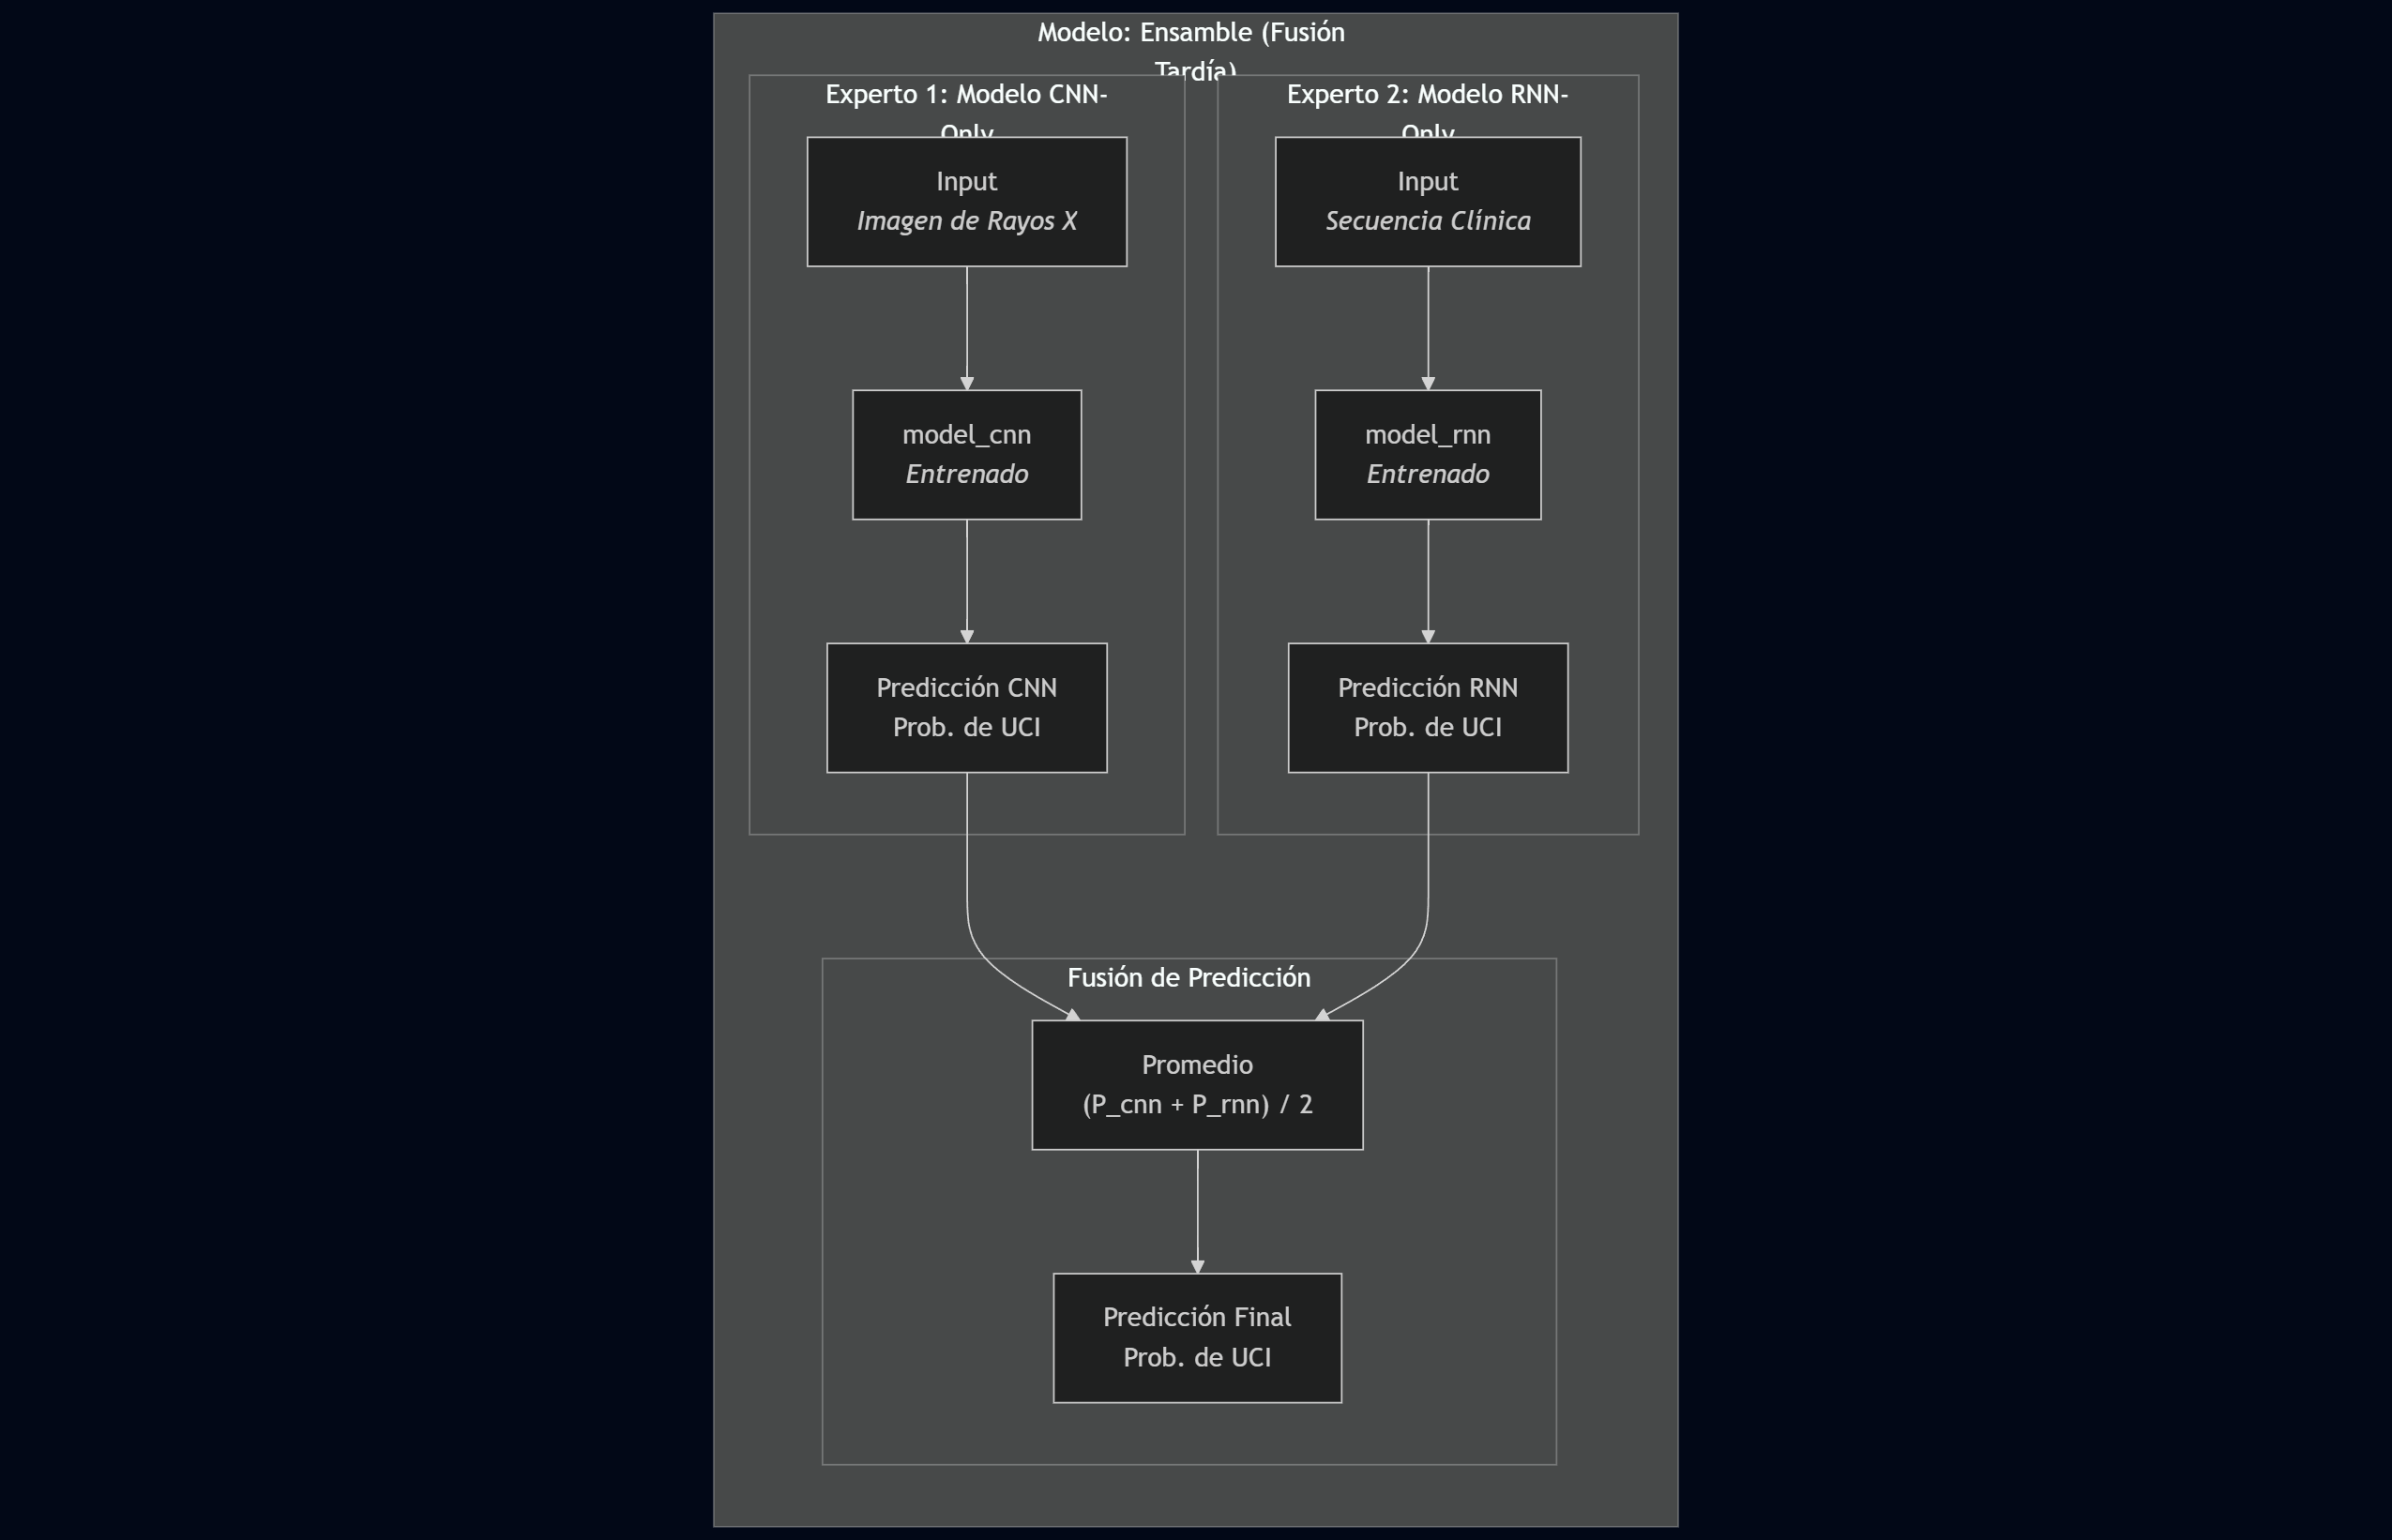